# <center> **Quantum Regression** </center> 

 - A variational quantum regressor is trained ad its architecture is optimized for various datasets
___

In [1]:
from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK, STATUS_FAIL

from pickle import dump, load
import gzip

import numpy as np
import pandas as pd
from scipy.stats import binned_statistic as binStats

import tensorflow as tf

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns

from os import popen

from datetime import datetime, timedelta

#bug? On lab machines quibo import fails requiring at least version 2.2.0, but tf version is 2.10.0
try:
    import qibo
except RuntimeError:
    tfvers = tf.__version__
    print(f"Modified tensorflow version while importing qibo (tf.__version__ = {tfvers})")
    tf.__version__ = "2.9.0"
    import qibo
    tf.__version__ = tfvers

from qibo import models, gates

___

In [2]:
RANDSEED = 42

In [27]:
plt.rcParams.update({'figure.figsize': [15.0, 10.0],
                     'figure.dpi' : 300,
                     'font.size': 18.0, 
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

qibo.set_backend("numpy")

[Qibo 0.2.2|INFO|2024-01-21 23:56:34]: Using numpy backend on /CPU:0


___
# Load Datasets

In [295]:
datasetName = "testDataset_1dim"
#datasetName = "testDataset_2dim"

#datasetName = "housing"
#datasetName = "housing_lessFeatures"

#datasetName = "cars"
#datasetName = "cars_lessFeatures"

#datasetName = "co2_mlo_1var"
#datasetName = "co2_mlo_2var"


X_train, y_train, X_val, y_val, X_test, y_test, INPUT_SHAPE = load(gzip.open(f"DatasetsProcessed/{datasetName}", "rb"))


nFeatures = 1
for i in INPUT_SHAPE:
        nFeatures *= i

___
# Hyperparameters Optimization

### CAMBIARE FUNZIONE IN PREDICT!!

In [396]:
################# Create circuit model with architecture determined by "ansatzType", and variable number of layers and gate repeats #################

def makeCircuitAnsatz(layers, nFeatures, ansatzType, repeats):
    #each circuit "unit" is repeated layers times
    #each parametrized gate in the unit is repeated repeats times (probably similar effect to adding layers)
    
    if ansatzType == "linear":
    # circuit "unit": -RZ-RY-H- * nFeatures
    # RZ theta = a + b * x_i
    # RY theta = c
        c = models.Circuit(1)
        c.add(gates.H(0))
        for _ in range(layers):
            for _ in range(nFeatures):
                for _ in range(repeats):
                    c.add(gates.RZ(0, theta=0))
                    c.add(gates.RY(0, theta=0))
                    c.add(gates.H(0))
                    
        c.add(gates.M(0))
        
        params_shape = (layers, nFeatures, repeats, 3,)
        
  
    elif ansatzType == "abs":
    # like a linear ansatz architecture, but the gates are parametrized differently:
    # RZ theta = a + b * |x-c|
    # RY theta = d
    # (idea is to make the model easily gain "peak" sensibility to certain range in data input)
        c = models.Circuit(1)
        c.add(gates.H(0))
        
        for _ in range(layers):
            for _ in range(nFeatures):
                    for _ in range(repeats):
                        c.add(gates.RZ(0, theta=0))
                        c.add(gates.RY(0, theta=0))
                        c.add(gates.H(0))

        c.add(gates.M(0))
        
        params_shape = (layers, nFeatures, repeats, 4,)

        
    elif ansatzType == "2qubits":
    # circuit "unit" (output is read on qubit 0)
    #     ----------------------------CRZ-CRY-CRX-
    #                                  |   |   |    
    #     -- (RZ-RY-H-) * nFeatures ---o---o---o--
    #
    # gates in 2nd qubit are parametrized like: thetaRZ = a + b * x_i, thetaRY = c
    # controlled gates in 1st qubit are not dependent on input x: thetaCRZ = d, thetaCRY = e, thetaCRZ = f
        c = models.Circuit(2)
        
        for _ in range(layers):
            for _ in range(nFeatures):
                for _ in range(repeats):
                    c.add(gates.RZ(1, theta=0))
                    c.add(gates.RY(1, theta=0))
                    c.add(gates.H(1))
            for _ in range(repeats):
                c.add(gates.CRZ(1,0,theta=0))
                c.add(gates.CRY(1,0,theta=0))
                c.add(gates.CRZ(1,0,theta=0))


        
        c.add(gates.M(0))
        
        params_shape = (layers, nFeatures+1, repeats, 3,)
        
    elif ansatzType == "deep":
    # circuit "unit" (output is read on qubit 0)
    #     --------CRZ-CRY--CRZ-CRY-
    #              |   |    |   |
    #     -RZ-RY---o---o----|---|--    |
    #                       |   |      | * nFeatures deep
    #     -RZ-RY------------o---o--    v
    #
    # gates in deep qubits and controlled gates in first qubit are parametrized like: thetaRZ = a + b * x_i, thetaRY = c

        c = models.Circuit(nFeatures+1)
        
        for _ in range(layers):
            for f in range(nFeatures):
                for _ in range(repeats):
                    c.add(gates.RZ(f+1, theta=0))
                    c.add(gates.RY(f+1, theta=0))
                
                    c.add(gates.CRZ(f+1, 0, theta=0))
                    c.add(gates.CRY(f+1, 0, theta=0))
        
        c.add(gates.M(0))
                          
        params_shape = (layers, nFeatures, repeats, 6,)
                          
    else:
        raise NotImplementedError(f"No implementation for ansatzType={ansatzType}")
        
    return c, params_shape





################# Precalculate circuit parameters for each element of the dataset #################

def getCircuitParameters(params, X, nFeatures, layers, ansatzType, repeats):
    
    parList = []
    
    if ansatzType == "linear":
        for l in range(layers):
            for f in range(nFeatures):
                for r in range(repeats):
                    parList.append(params[l,f,r,0] + params[l,f,r,1]*X[:,f])
                    parList.append(params[l,f,r,2]*np.ones(X.shape[0]))
                
    elif ansatzType == "abs":
        for l in range(layers):
            for f in range(nFeatures):
                for r in range(repeats):
                    parList.append(params[l,f,r,0] + params[l,f,r,1]*np.abs(X[:,f]-params[l,f,r,2]))
                    parList.append(params[l,f,r,3]*np.ones(X.shape[0]))

    elif ansatzType == "2qubits":
        for l in range(layers):
            for f in range(nFeatures):
                for r in range(repeats):
                    parList.append(params[l,f,r,0] + params[l,f,r,1]*X[:,f])
                    parList.append(params[l,f,r,2]*np.ones(X.shape[0]))
            for r in range(repeats):
                parList.append(params[l,nFeatures,r,0]*np.ones(X.shape[0]))
                parList.append(params[l,nFeatures,r,1]*np.ones(X.shape[0]))
                parList.append(params[l,nFeatures,r,2]*np.ones(X.shape[0]))
                          
    elif ansatzType == "deep":
        for l in range(layers):
            for f in range(nFeatures):
                for r in range(repeats):
                    parList.append(params[l,f,r,0] + params[l,f,r,1]*X[:,f])
                    parList.append(params[l,f,r,2]*np.ones(X.shape[0]))
                    parList.append(params[l,f,r,3] + params[l,f,r,4]*X[:,f])
                    parList.append(params[l,f,r,5]*np.ones(X.shape[0]))

    else:
        raise NotImplementedError(f"No implementation for ansatzType={ansatzType}")      
    
    return np.stack(parList, axis=-1)





################# Predict target values for data X #################

def predict(X, params, nFeatures, ansatzType, layers, repeats, circuit=None, parShape=None):
    if (circuit != None) and (parShape != None):
        circuit = circuit
        parShape = parShape
    else:
        circuit, parShape = makeCircuitAnsatz(layers, nFeatures, ansatzType, repeats)
    y_pred = []
    par = params.reshape(parShape)
    circuitParams = getCircuitParameters(par, X, nFeatures, layers, ansatzType, repeats)
    for i,x in enumerate(X):
        state = circuit.set_parameters(circuitParams[i])
        prob = circuit(nshots=1024).probabilities([0])
        
        #y_pred.append(prob[0]) #target values are in [0,1] --> using as prediction 0.5 * (prob[|0>] - prob[|1>] + 1)
        y_pred.append(2*prob[0] - 0.5) #ouput values are in [-0.5, 1.5] --> more flexible for CO2 extrapolation
        
    return y_pred




################# Compute mean squares loss for given data and model architecture #################

def loss(params, circuit, X, y, nFeatures, layers, ansatzType, repeats, params_shape, verbose): 
    
    y_pred = predict(X, params, nFeatures, ansatzType, layers, repeats, circuit, params_shape)
    loss = np.sum((y - y_pred) ** 2)/len(y)

    if verbose > 1:
        print(f"Computed Loss    --->    loss={loss}", flush=True)
        
    return loss
    


################# Train model with given architecture #################
class TrainManager:
    def __init__(self, batch_size, X_train, y_train, X_val, y_val, layers, ansatzType, nFeatures, repeats, epochs, verbose=0, startParams=None):
        self._X_train = X_train
        self._y_train = y_train
        self._X_val = X_val
        self._y_val = y_val
        
        self._batch_size = min(len(self._y_train), batch_size) if batch_size != "full" else len(self._y_train)
        self._val_batch_size = min(len(self._y_val), batch_size) if batch_size != "full" else len(self._y_val)
        self.updateBatches()

        
        self.layers = layers
        self.ansatzType = ansatzType
        self.nFeatures = nFeatures
        self.repeats = repeats
        self.epochs=epochs
        self.verbose=verbose
        circuit, params_shape = makeCircuitAnsatz(self.layers, self.nFeatures, self.ansatzType, self.repeats)
        self.circuit = circuit
        self.params_shape = params_shape
        self.startParams = startParams
        self._hist_par = []
        self._hist_loss = []
        self._hist_valLoss = []
       
    def updateBatches(self):
        idxs = np.random.choice(range(len(y_train)), self._batch_size, replace=False)
        self._X_batch = X_train[idxs]
        self._y_batch = y_train[idxs]

        idxs = np.random.choice(range(len(y_val)), self._val_batch_size, replace=False)
        self._X_val_batch = X_val[idxs]
        self._y_val_batch = y_val[idxs]        

        
    def callback(self, params):
        self._hist_par.append(params)
        self._hist_loss.append(loss(params, self.circuit, self._X_batch, self._y_batch, self.nFeatures, self.layers, self.ansatzType, self.repeats, self.params_shape, self.verbose))
        self._hist_valLoss.append(loss(params, self.circuit, self._X_val_batch, self._y_val_batch, self.nFeatures, self.layers, self.ansatzType, self.repeats, self.params_shape, self.verbose))
        self.updateBatches()
        
    def train(self):
        if type(self.startParams) == type(None):
            params_init = np.random.sample(self.params_shape)
        else:
            params_init = self.startParams.reshape(self.params_shape)

        self._hist_par = []
        self._hist_loss = []
        self._hist_valLoss = []

        #do a few circuit evaluations to estimate training time:
        if self.verbose >= 0:

            start = datetime.now()
            pars_tmp = getCircuitParameters(params_init, self._X_batch, self.nFeatures, self.layers, self.ansatzType, self.repeats)

            for i in range(min(len(pars_tmp),100)):
                self.circuit.set_parameters(pars_tmp[i])
                self.circuit.execute(nshots=1024).probabilities([0])
            end = datetime.now()

            ext_training_time = 2*(end-start)/min(len(pars_tmp),100)*self._batch_size*len(pars_tmp[0]+1)*(self.epochs+1)

            if ext_training_time > timedelta(hours=MAX_HOURS_TRIAL):
                ext_training_time = str(ext_training_time).split(".")[0]
                print(f"Estimated training time is too long ({ext_training_time}), going to next trial!\n\n")
                raise RuntimeError

            ext_training_time = str(ext_training_time).split(".")[0]


            timeStart = datetime.now().strftime("%x %X")

            print(f"Training Started: {timeStart} -- Estimated training time: {ext_training_time}\n\n", flush=True)

        #train model
        start = datetime.now()
        _, parameters, _ = qibo.optimizers.optimize(loss,
                                                    params_init.flatten(),
                                                    args=(self.circuit, self._X_batch, self._y_batch, self.nFeatures, self.layers, self.ansatzType, self.repeats, self.params_shape, self.verbose),
                                                    method='parallel_L-BFGS-B', options={'maxiter':self.epochs, 'disp':self.verbose},
                                                    callback=self.callback                                                   )
        end = datetime.now()

        if self.verbose >= 0:
            print(f"\nTraining Time: {end-start}\n\n", flush=True)

        return parameters, self._hist_par, self._hist_loss, self._hist_valLoss
        


################# Train multiple models to find optimal hyperparameters #################

class TrialManager:
    def __init__(self, batch_size, Xtrain, ytrain, Xval, yval, nFeatures, epochs, verbose=0):
        self._batch_size = len(ytrain) if batch_size == "full" else min(len(ytrain),batch_size)
        self._val_batch_size = len(yval) if batch_size == "full" else min(len(yval), batch_size)
        self._Xtrain = Xtrain
        self._ytrain = ytrain
        self._Xval = Xval
        self._yval = yval
        self._verbose = verbose
        self._nFeatures = nFeatures
        self.epochs = epochs
        
    def hyperopt_func(self, hyperParams):
        layers = int(hyperParams["layers"])
        ansatzType = hyperParams["ansatzType"]
        repeats = int(hyperParams["repeats"])
        epochs = self.epochs
        print(f"Training Model with :\n\t- {layers} hidden layers\n\t- {repeats} repeats\n\t- ansatz = {ansatzType}\n\n")
        
        #try:
            
        trainMgr = TrainManager(self._batch_size, self._Xtrain, self._ytrain, self._Xval, self._yval, layers=layers, ansatzType=ansatzType, nFeatures=self._nFeatures, repeats=repeats, epochs=epochs, verbose=self._verbose, startParams=None)

        bestParams, params_hist, loss_hist, val_loss_hist = trainMgr.train()


        print(f"\nTraining successful: loss={val_loss_hist[-1]:.5f}\n\n\n")

        return {"loss" : val_loss_hist[-1], "status" : STATUS_OK, "bestParams" : [bestParams], "history" : [{"params_hist" : params_hist, "loss" : loss_hist, "val_loss" : val_loss_hist}]}

#        except KeyboardInterrupt:
#            raise KeyboardInterrupt

#        except:
#            print("Training Failed, next trial\n\n\n")
#            return {"status" : STATUS_FAIL}
        
search_space = {
    "layers" : 12,
    "ansatzType" : "abs",
    "repeats" : 1
}

In [397]:
search_space.update({
    "layers" : hp.quniform("layers", 5, 15, 1),
    "ansatzType" : hp.choice("ansatzType", ["linear", "abs", "2qubits", "deep"]),
#    "repeats" : hp.quniform("repeats", 1, 5, 1),
})

In [ ]:
BATCH_SIZE = 50
TOT_TRIALS = 50
EPOCHS = 100
MAX_HOURS_TRIAL = 1
VERBOSE = 0 # (-1: only trial recap; 0: training time + scipi.optimize results; 1:scipi.optimize steps; 2: batch sizes, every loss function execution)

# Start a new hyperparameter search (overwrites old trials!!)
trials = Trials()
# or resume previous one
#trials = load(gzip.open(f"Variables/QML_Trials/hp_trials_QML_{datasetName}", "rb"))

trialMgr = TrialManager(BATCH_SIZE, X_train, y_train, X_val, y_val, nFeatures,EPOCHS, VERBOSE)
for i in range(len(trials.trials)+1, TOT_TRIALS+1):
    print(f"-------------------    TRIAL {i}/{TOT_TRIALS}    -------------------\n\n")
    fmin(trialMgr.hyperopt_func, search_space, algo=tpe.suggest, max_evals=i, trials=trials, show_progressbar=False)
    
    if i==1 or i%1==0:
        print("-----------------------------------------------------------\n\n")
        print("Dumping trials... don't ctrl-c now...", end='')
        #dump(trials, gzip.open(f"Variables/QML_Trials/hp_trials_QML_{datasetName}", "wb"))
        print(" Done!\n\n")

-------------------    TRIAL 1/50    -------------------


Training Model with :
	- 7 hidden layers
	- 1 repeats
	- ansatz = abs


Training Started: 01/22/24 15:32:10 -- Estimated training time: 0:02:32




## Hyperparameters search results

In [238]:
#Load trials, get best hyperparameters, trained model and training history
def trials_to_DataFrame(trials_list, search_space=search_space, 
                        trials_columns=['loss', 'layers', 'repeats', 'ansatzType', "bestParams", "history"], 
                        columns_new_names = ["Loss", "Layers","Repeats", "Type of Ansatz Circuit", "bestParams", "history"]):

    trials_df_list = []
    for trials in trials_list:
        def unpack(x):
            try:
                return x[0]
            except:
                return x

        trials_ok = [trial for trial in trials.trials if trial["result"]["status"] == STATUS_OK]
        
        lossTrials = pd.DataFrame([trial["result"]["loss"] for trial in trials_ok], columns=["loss"])
        weightsTrials = pd.DataFrame([trial["result"]["bestParams"] for trial in trials_ok], columns=["bestParams"])
        historyTrials = pd.DataFrame([trial["result"]["history"] for trial in trials_ok], columns=["history"])
        paramsTrials = pd.DataFrame([trial["misc"]["vals"] for trial in trials_ok], columns=search_space.keys()).applymap(unpack)
        paramsTrials = paramsTrials.T.apply(lambda x: space_eval(search_space, x))
        paramsTrials = pd.DataFrame.from_records(paramsTrials.values)

        trials_df = pd.concat([lossTrials, paramsTrials, weightsTrials, historyTrials], axis=1)
        

        #making sure columns are in the correct order and then renaming for better axis labels
        trials_df = trials_df[trials_columns]
        trials_df.columns = columns_new_names
    
        #adding to list
        trials_df_list.append(trials_df)
    
    return pd.concat(trials_df_list, axis=0).reset_index().drop(["index"], axis=1)

In [379]:
#Load previous trials
#trials = load(gzip.open(f"Variables/QML_Trials/hp_trials_QML_{datasetName}", "rb"))

trials_df = trials_to_DataFrame([trials])
trials_df["LogLoss"] = np.log(trials_df["Loss"])

In [380]:
trials_df.sort_values("Loss")

Loss  Layers  Repeats Type of Ansatz Circuit  \
0  0.006786    15.0        1                    abs   
2  0.013323     5.0        1                   deep   
1  0.066985     6.0        1                    abs   

                                          bestParams  \
0  [0.23538959236755222, 1.0633850508115583, 0.56...   
2  [0.9283306378881437, 0.8095879271073471, 0.967...   
1  [0.45558172250880197, 1.6150562290204942, 0.24...   

                                             history   LogLoss  
0  {'params_hist': [[0.28191092023927466, 1.00588... -4.992924  
2  {'params_hist': [[0.9283199172495444, 0.809565... -4.318275  
1  {'params_hist': [[0.9232267779237636, 0.963653... -2.703282

In [268]:
#remove outliers
threshold = trials_df["Loss"].mean() + 5 * trials_df["Loss"].std()
trials_df = trials_df[trials_df["Loss"] < threshold]

### Choose Best Model, a random one or a specific trial

In [381]:
idx_best = trials_df["Loss"].idxmin() #Best Model
#idx_best = np.random.choice(trials_df.index) #Random Trial
#idx_best = 4 # Specific Trial

trials_df.loc[[idx_best]]

Loss  Layers  Repeats Type of Ansatz Circuit  \
0  0.006786    15.0        1                    abs   

                                          bestParams  \
0  [0.23538959236755222, 1.0633850508115583, 0.56...   

                                             history   LogLoss  
0  {'params_hist': [[0.28191092023927466, 1.00588... -4.992924

___

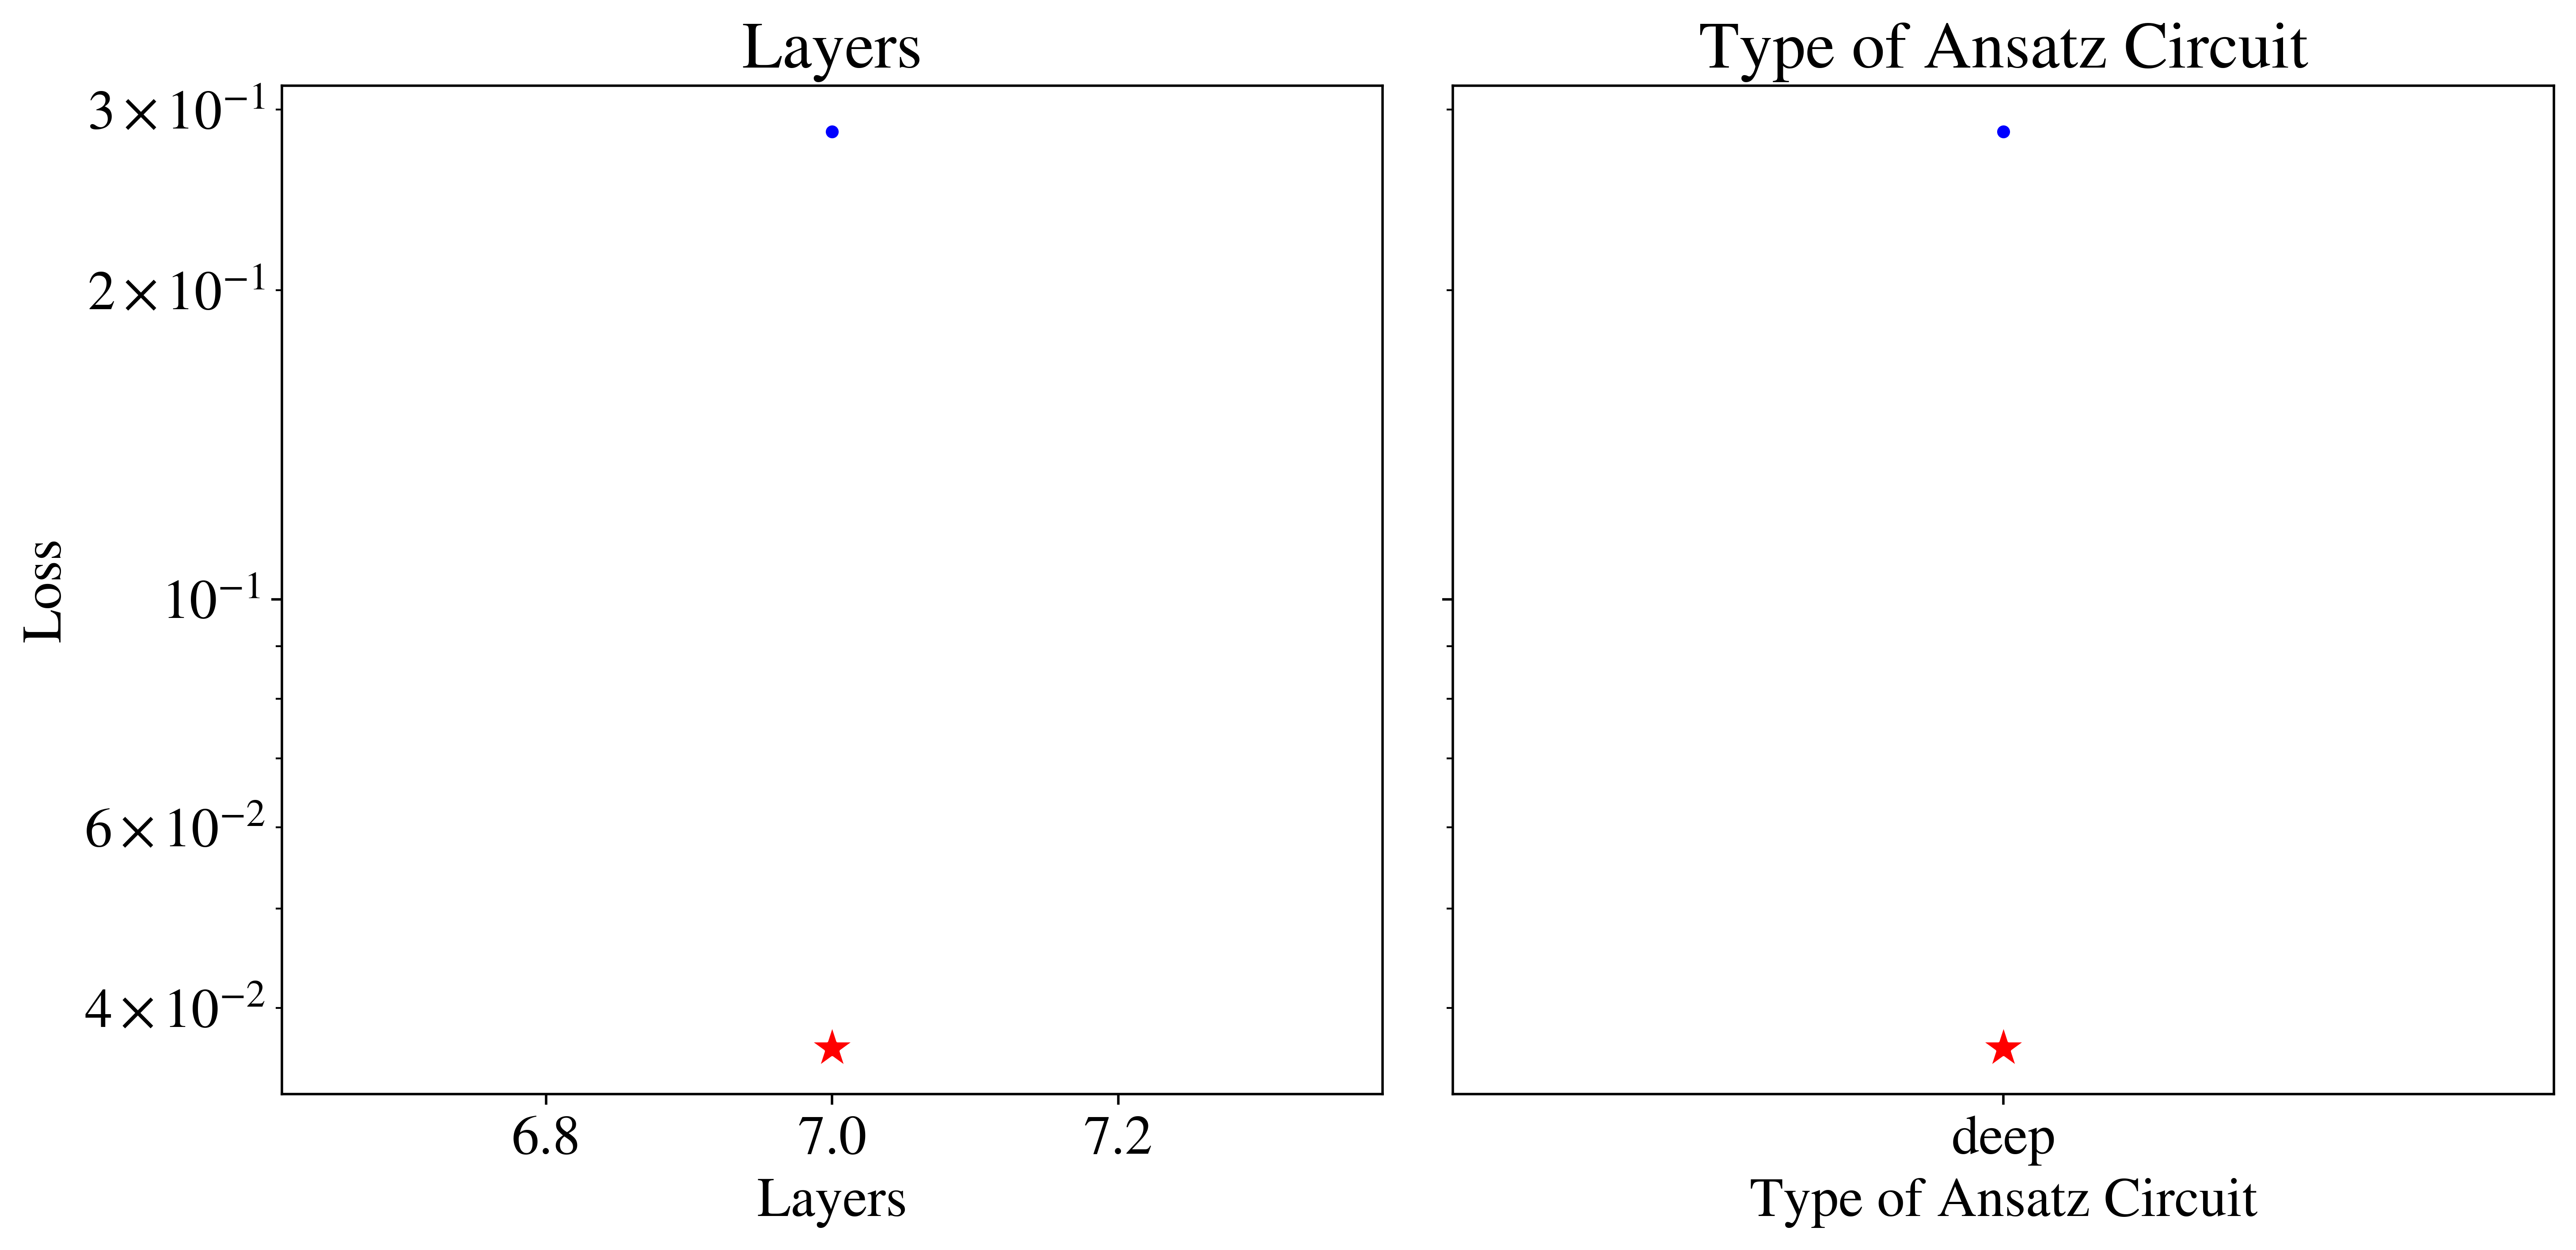

In [374]:
cols = trials_df.columns.drop(["Loss", "LogLoss", "bestParams", "history", "Repeats"])

fig, ax = plt.subplots(1,len(cols), sharey=True, figsize=(12,6), dpi=500)

#fig.suptitle("Loss for different hyperparameters", size=25)

for i, hyperParam in enumerate(cols):
    ax[i].set_title(hyperParam)
    sns.scatterplot(data=trials_df, x=hyperParam, y="Loss", ax=ax[i], color="blue", marker=".", s=100)
    sns.scatterplot(data=trials_df.loc[[idx_best],:], x=hyperParam, y="Loss", ax=ax[i], marker="*", color="red", linewidth=1, s=250)
    
    ax[i].set_yscale("log")
    #ax[i].ticklabel_format(style='sci',scilimits=(0,0),axis='y')
    
    #Show trial number
    #[ax[i].annotate(idx, (trials_df.loc[idx,hyperParam], trials_df.loc[idx,"Loss"]), fontsize=8, fontweight="bold") for idx in trials_df.reset_index()["index"].values]#

plt.tight_layout()
#plt.savefig(f"Figures/lossHyperParams_QML_{datasetName}.pdf", format="pdf", pad_inches=0)
plt.show()

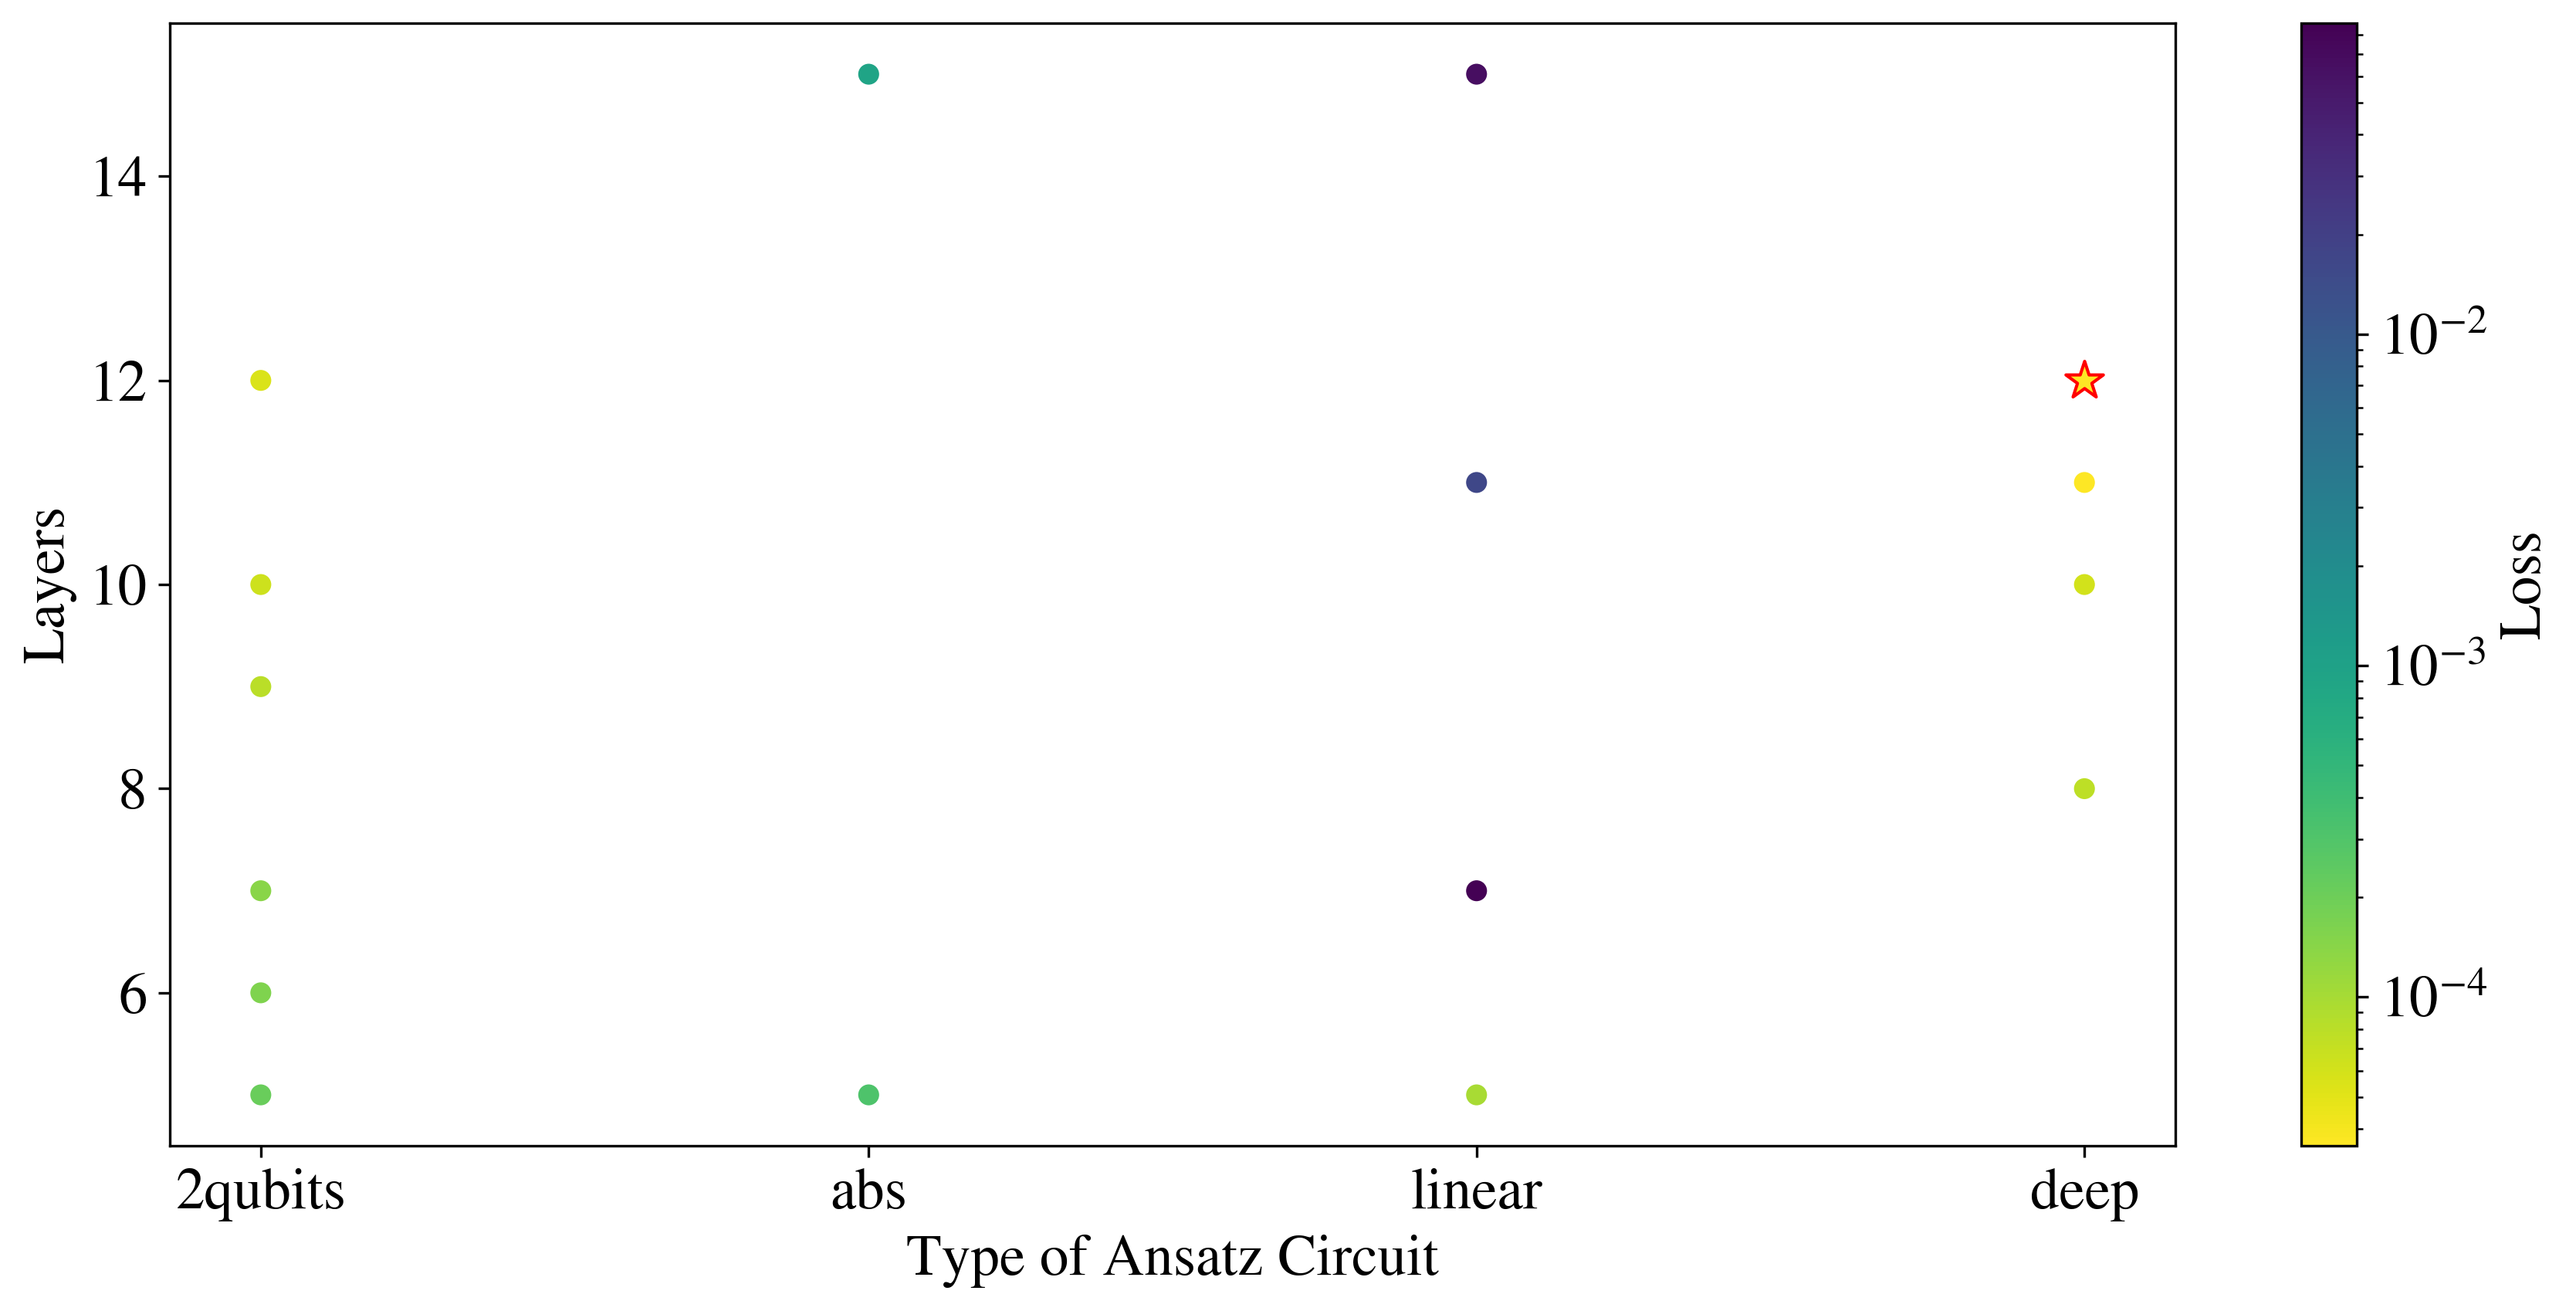

In [291]:
tmp_df = trials_df[["Loss", "LogLoss", "Layers", "Type of Ansatz Circuit"]]
tmp_df = tmp_df.loc[tmp_df.groupby(["Layers", "Type of Ansatz Circuit"])["Loss"].idxmin()]

plt.figure(figsize=(12,6))
#plt.title(r"Best Loss depending on Network Architecture", size=28)
sns.scatterplot(data=tmp_df.drop(idx_best, axis=0), x="Type of Ansatz Circuit", y="Layers", hue="LogLoss", palette="viridis_r", s=50);
sns.scatterplot(data=tmp_df.loc[[idx_best],:], x="Type of Ansatz Circuit", y="Layers", hue="LogLoss", palette="viridis_r", marker="*", edgecolor="red", s=150);

#colorbar
norm = matplotlib.colors.LogNorm(tmp_df['Loss'].min(), tmp_df['Loss'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
ax = plt.gca()
ax.get_legend().remove()
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.set_ylabel(r"Loss", rotation=90)

#Show trial index
#[plt.annotate(idx, (tmp_df.loc[idx,"Layers"], tmp_df.loc[idx,"Type of Ansatz Circuit"]), fontsize=7) for idx in tmp_df.reset_index()["index"].values]

plt.tight_layout()
#plt.savefig(f"Figures/lossArchitecture_QML_{datasetName}.pdf", format="pdf", pad_inches=0)
plt.show()


___
# Best Model

In [382]:
#Printing Best Trial and Model
print("\nBest Trial:")
display(trials_df.loc[[idx_best], ["Loss",  "Layers", "Type of Ansatz Circuit", "Repeats"]])
print("\n\n")

layers = int(trials_df.loc[idx_best,"Layers"])
ansatzType = trials_df.loc[idx_best,"Type of Ansatz Circuit"]
repeats = int(trials_df.loc[idx_best, "Repeats"])


model, paramsShape = makeCircuitAnsatz(layers=layers,
                               nFeatures=nFeatures,
                               ansatzType=ansatzType,
                               repeats=repeats
                            )

print(model.draw(line_wrap=200), "\n\n", flush=True)
bestParams = trials_df.loc[idx_best,"bestParams"]


Best Trial:


Loss  Layers Type of Ansatz Circuit  Repeats
0  0.006786    15.0                    abs        1




q0: ─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─RZ─RY─H─M─ 




#### Make loss history for plotting

In [383]:
history = trials_df.loc[idx_best,"history"]

if "loss" not in history.keys():
    print("Computing Training Loss...", flush=True)
    history["loss"] = [loss(par, model, X_train, y_train, nFeatures, layers, ansatzType, repeats, paramsShape, verbose=2) for par in history["params_hist"]]
if  "val_loss" not in history.keys():
    print("\nComputing Validation Loss...", flush=True)
    history["val_loss"] = [loss(par, model, X_val, y_val, nFeatures, layers, ansatzType, repeats, paramsShape, verbose=2) for par in history["params_hist"]]        
    print("\nDone!", flush=True)

#### More epochs?

In [388]:
#train more
batch_size = 100
trainMgr = TrainManager(batch_size, 
                            X_train, y_train, 
                            X_val, y_val, 
                            layers=int(trials_df.loc[idx_best,"Layers"]), 
                            ansatzType=trials_df.loc[idx_best,"Type of Ansatz Circuit"], 
                            nFeatures=nFeatures, 
                            repeats=int(trials_df.loc[idx_best, "Repeats"]),
                            epochs=5, 
                            verbose=1,
                            startParams=bestParams
                       )
bestParams, newHist, newHistLoss, newHistValLoss = trainMgr.train()

history["params_hist"] = trials_df.loc[idx_best,"history"]["params_hist"] + newHist
history["loss"] = history["loss"] + newHistLoss
history["val_loss"] = history["val_loss"] + newHistValLoss

Training Started: 01/22/24 15:24:27 -- Estimated training time: 0:01:16


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           60     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18139D-03    |proj g|=  1.85190D-02


 This problem is unconstrained.



At iterate    1    f=  2.91561D-03    |proj g|=  1.58464D-02

At iterate    2    f=  2.73861D-03    |proj g|=  8.22561D-03

At iterate    3    f=  2.62783D-03    |proj g|=  6.19594D-03

At iterate    4    f=  2.53426D-03    |proj g|=  6.12915D-03


Training Time: 0:01:37.704464

At iterate    5    f=  2.37737D-03    |proj g|=  6.40477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   60      5      8      1     0     0   6.405D-03   2.377D-03
  F =   2.3773693563119156E-003

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 



#### Plot history

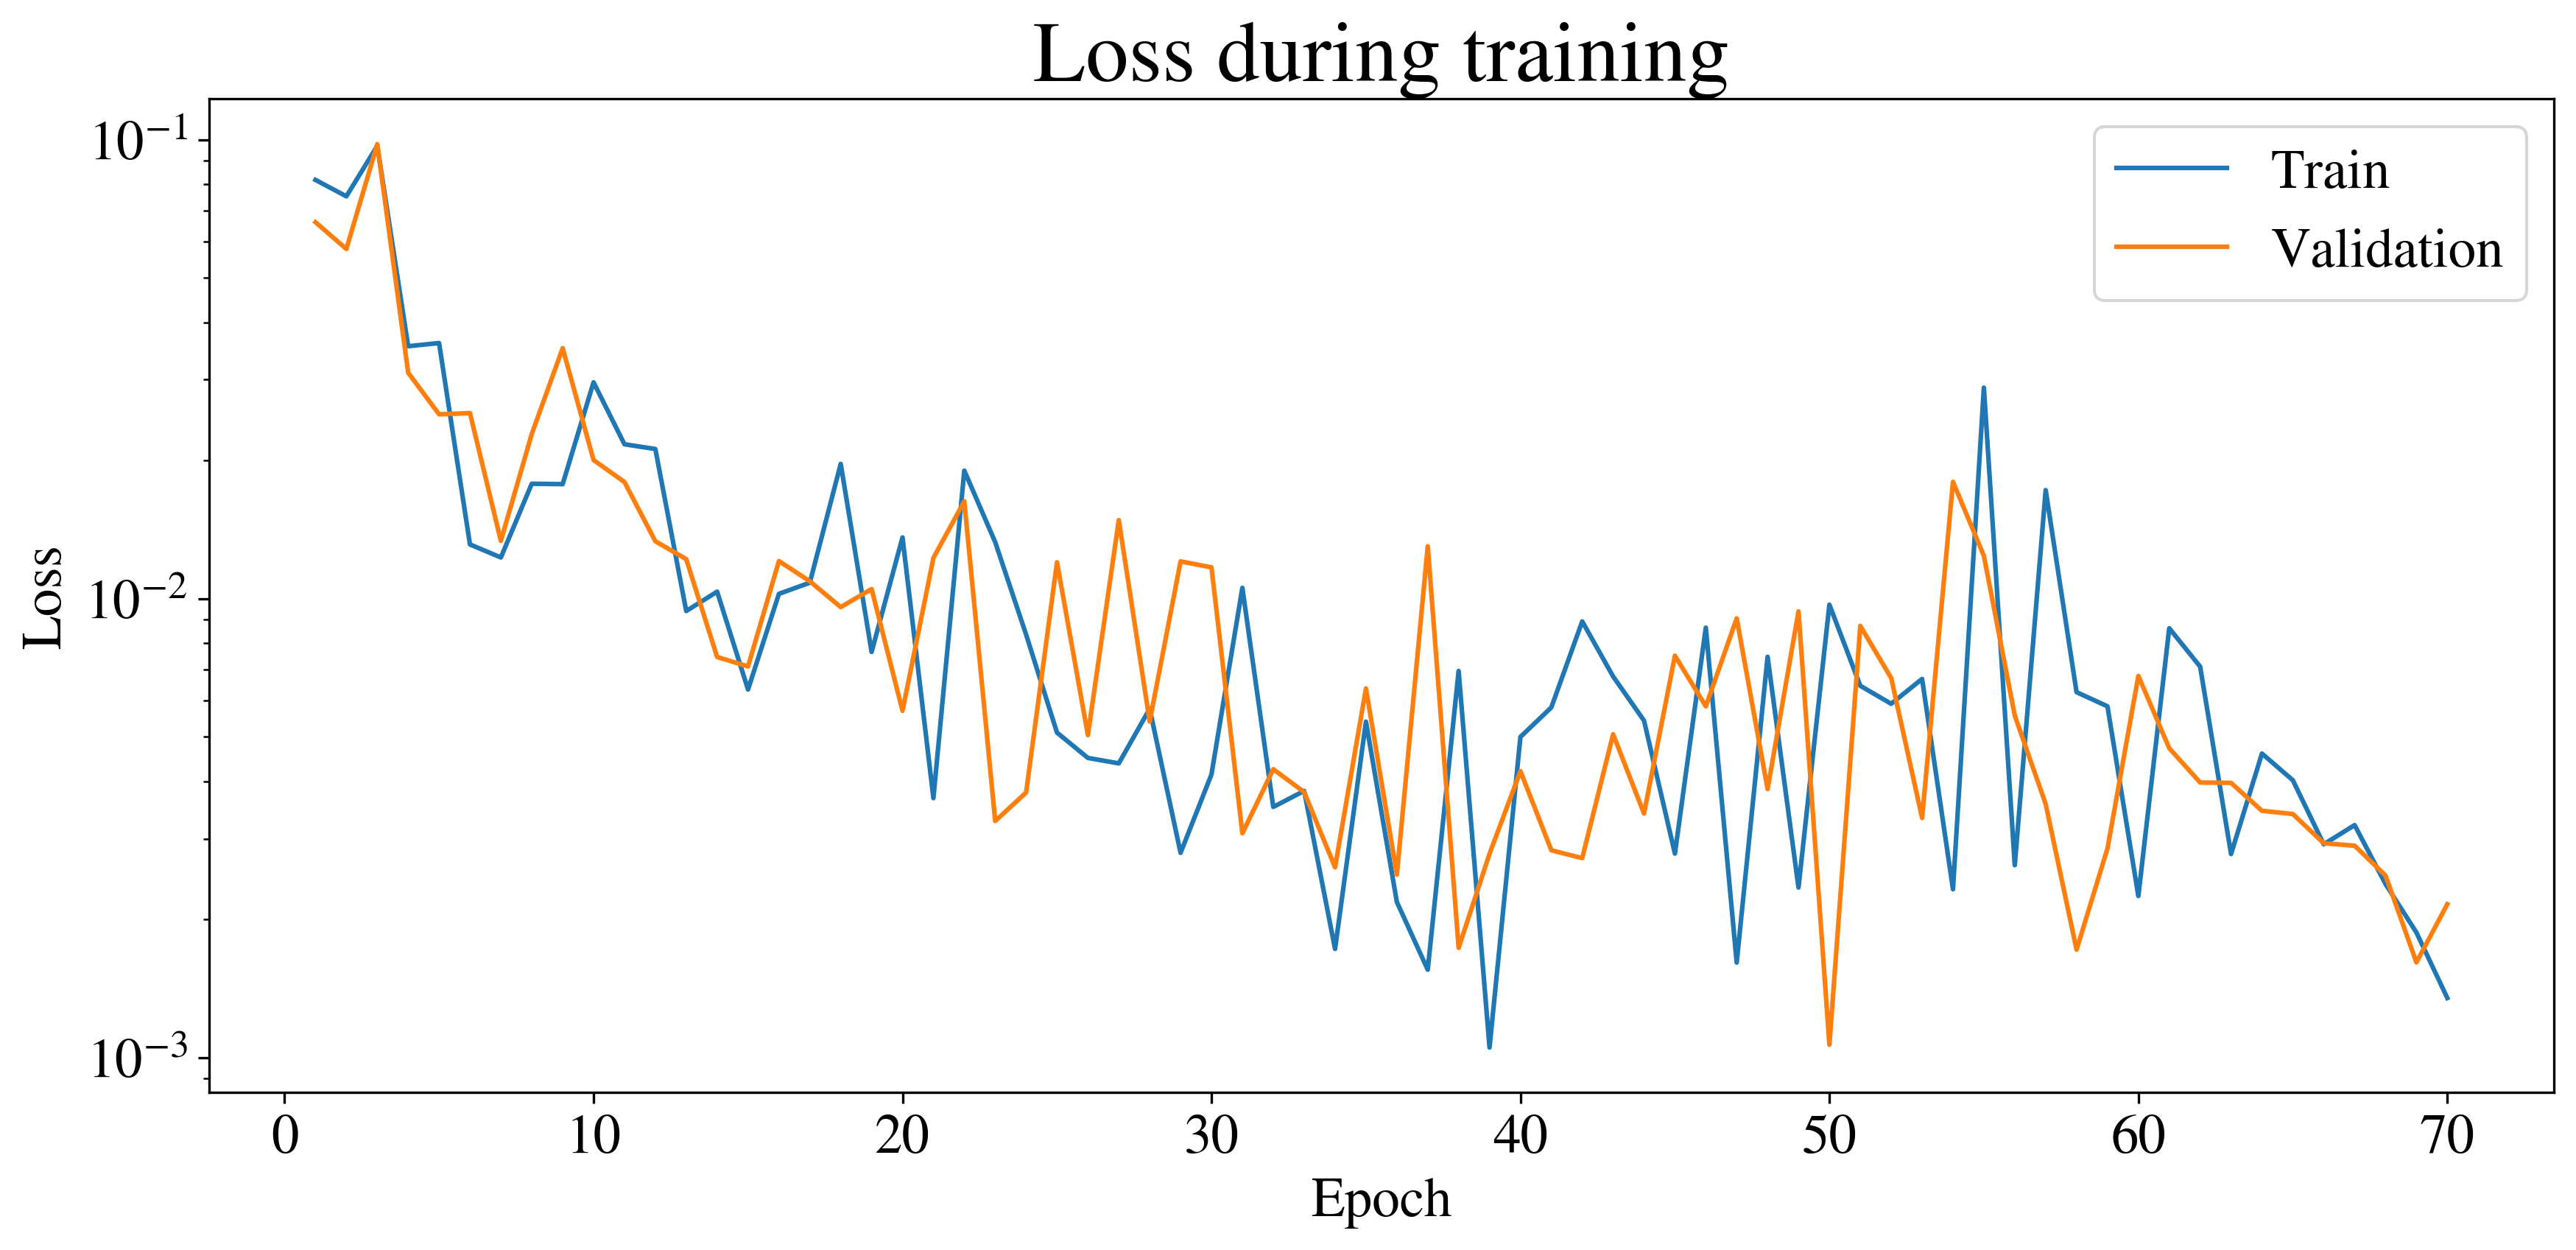

In [389]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(np.array(history["loss"]))+1), np.array(history["loss"]), label="Train")
plt.plot(range(1, len(np.array(history["loss"]))+1), np.array(history["val_loss"]), label="Validation")
plt.title("Loss during training", size=28)
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.tight_layout()
#plt.savefig(f"Figures/lossHistory_QML_{datasetName}.pdf", format="pdf", pad_inches=0)
plt.show()

## Best Model Evaluation

### Also load Classical for comparison

In [392]:
classicalModel = tf.keras.models.load_model(f"Variables/FFNN_BestModels/{datasetName}")

___

In [393]:
print(f"Number of params: {len(bestParams)}")

Number of params: 60


In [394]:
yX = [y_test, X_test]
#y_pred = predict(yX[1], params=bestParams, 
#                 nFeatures=nFeatures,
#                 ansatzType=trials_df.loc[idx_best,"Type of Ansatz Circuit"],
#                 layers=int(trials_df.loc[idx_best,"Layers"]),
#                 repeats = int(trials_df.loc[idx_best, "Repeats"])
#                )

y_pred = predict(yX[1], params=bestParams, 
                 nFeatures=nFeatures,
                 ansatzType="abs",
                 layers=15,
                 repeats = 1
                )


y_pred_classical = classicalModel.predict(X_test)

mean_squares_loss = np.sum((y_test - y_pred) ** 2)/len(y_test)
mean_absolute_error = np.sum(np.abs(y_test - y_pred))/len(y_test)

print( f"Test Loss = {mean_squares_loss}\nTest Mean Absolute Error = {mean_absolute_error}")

Test Loss = 0.0027588071252642532
Test Mean Absolute Error = 0.03382575892524221


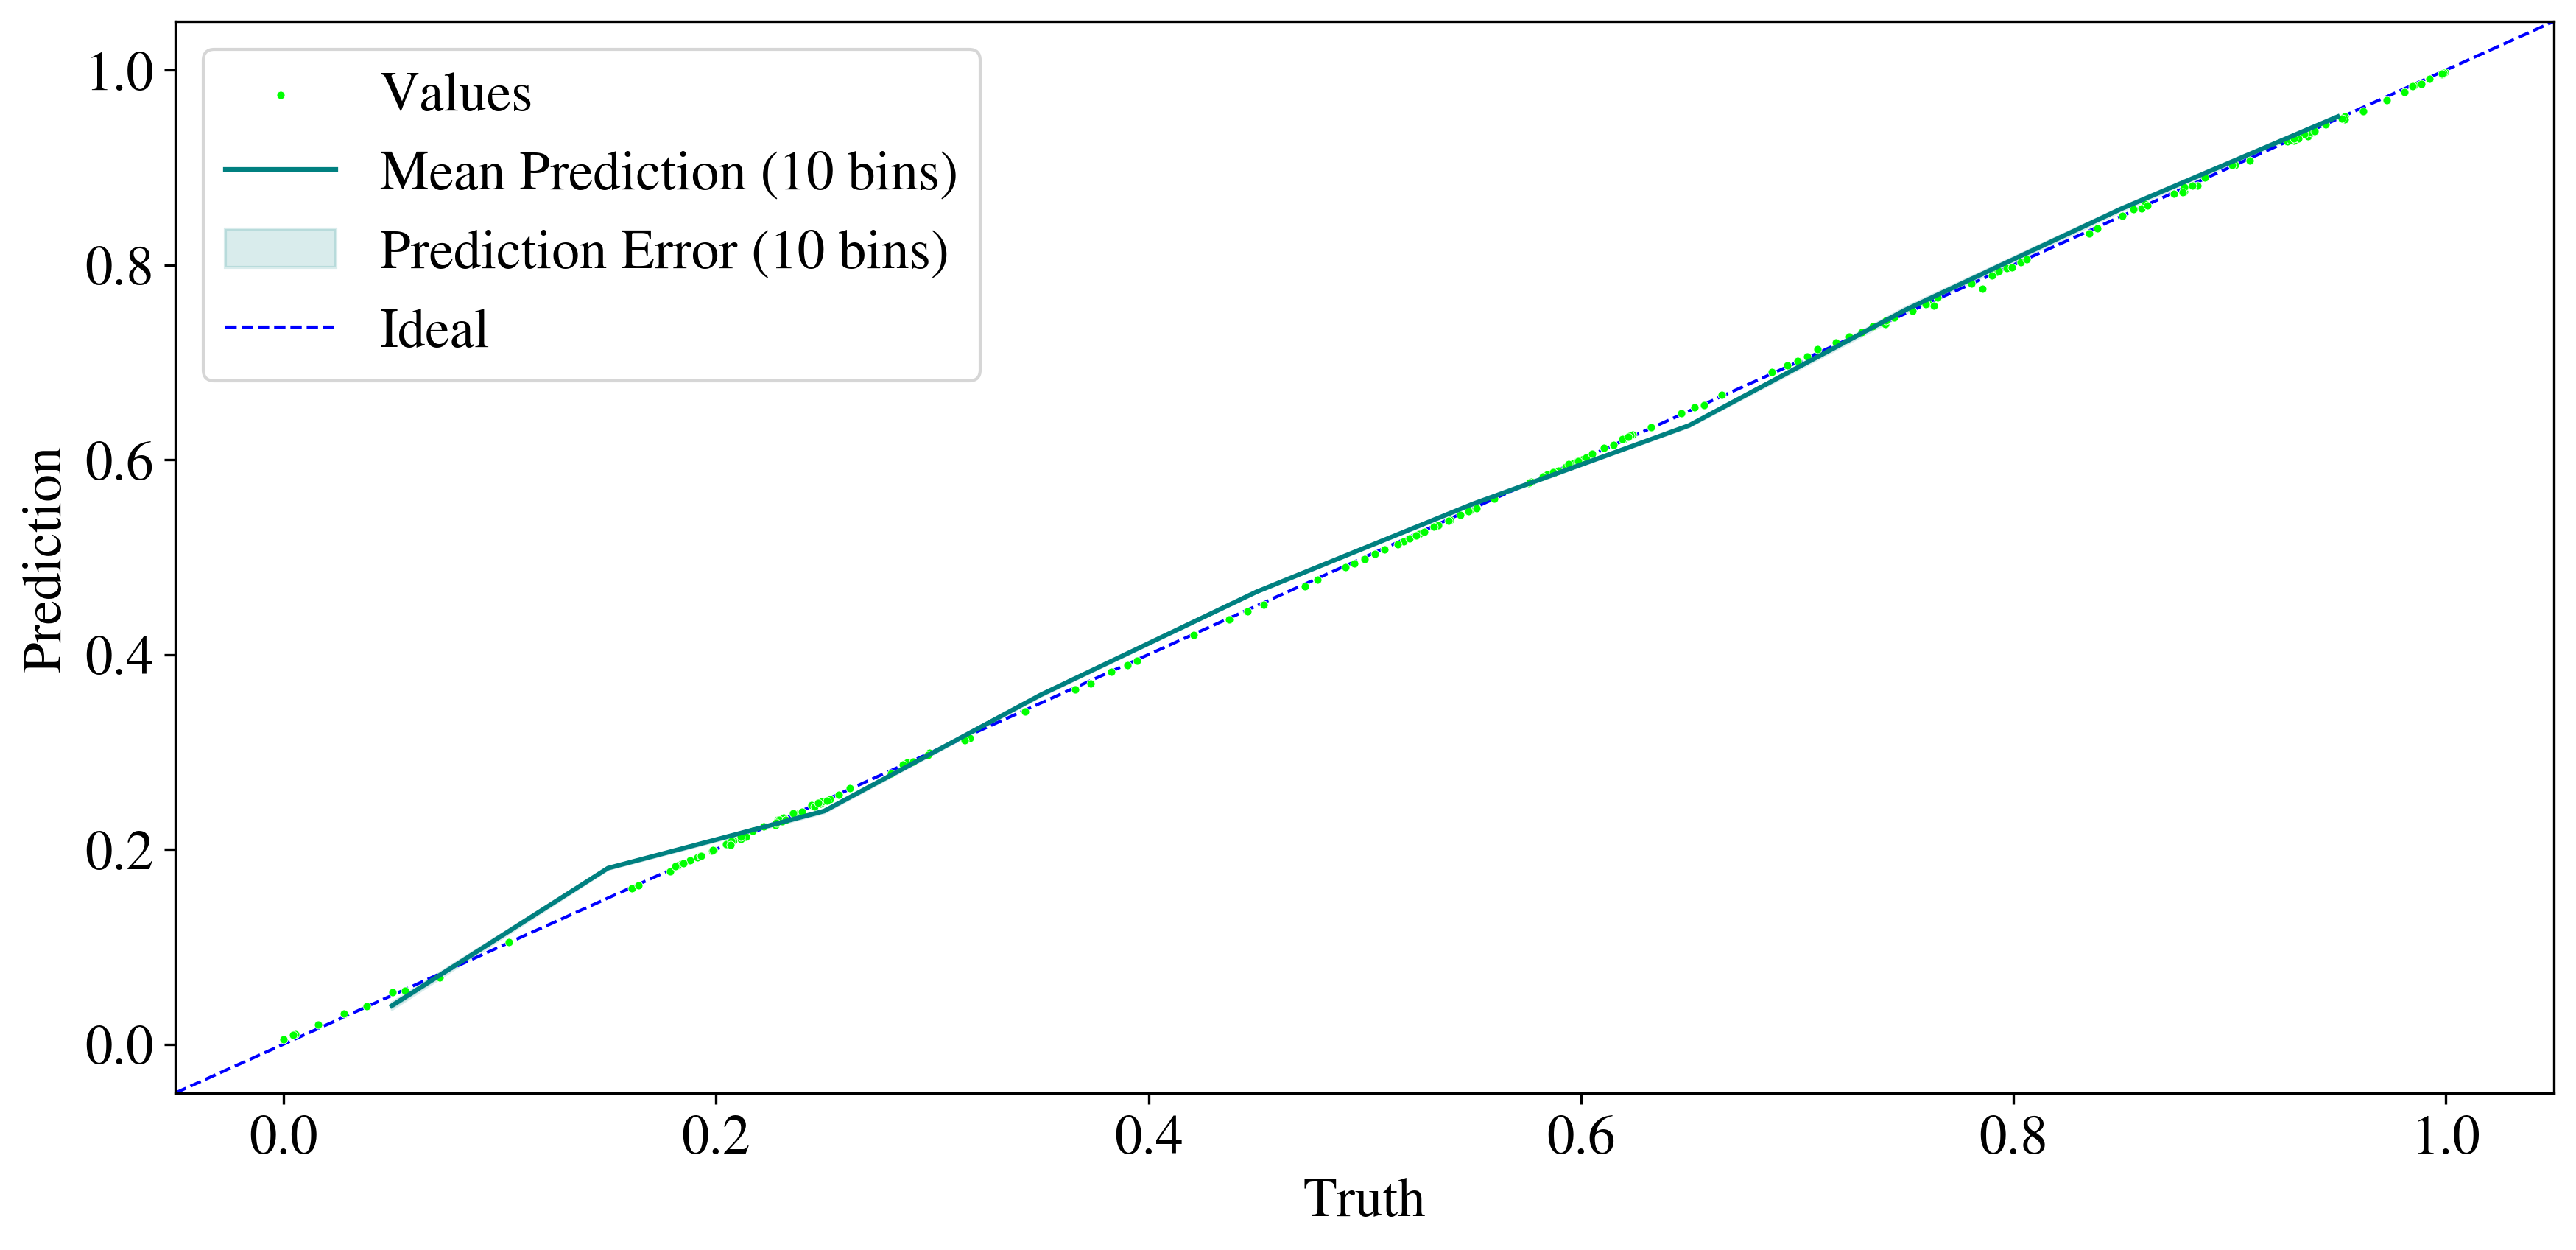

In [260]:
nBins=10

bins = np.linspace(0,1,nBins+1)
#bins = np.concatenate([np.linspace(0, .3, int(0.6*nBins), endpoint=False),np.linspace(.3,1, int(0.4*nBins)+1, endpoint=True)]) #for cars data
x = (bins[:-1] + bins[1:])/2
mean = binStats(yX[0], y_pred, "mean", bins=bins).statistic
std = binStats(yX[0], y_pred-yX[0], "std", bins=bins).statistic


plt.figure(figsize=(12,6))
#plt.title(f"Test set predictions and truth values", size=28)

plt.axline((0,0), (1,1), color="blue", lw=1, ls="dashed", label="Ideal")

plt.plot(x, mean, color="teal", lw=1.5, label=f"Mean Prediction ({nBins} bins)", zorder=3)
plt.fill_between(x, mean-std, mean+std, color="teal", alpha=0.15, label=f"Prediction Error ({nBins} bins)")

plt.scatter(yX[0], y_pred, s=7, color='lime',label="Values", zorder=2, ec="white", lw=0.2)


plt.xlabel('Truth')
plt.ylabel('Prediction')

plt.legend()

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.tight_layout()
#plt.savefig(f"Figures/true_pred_scatter_QML_{datasetName}.pdf", format="pdf", pad_inches=0)

plt.show()

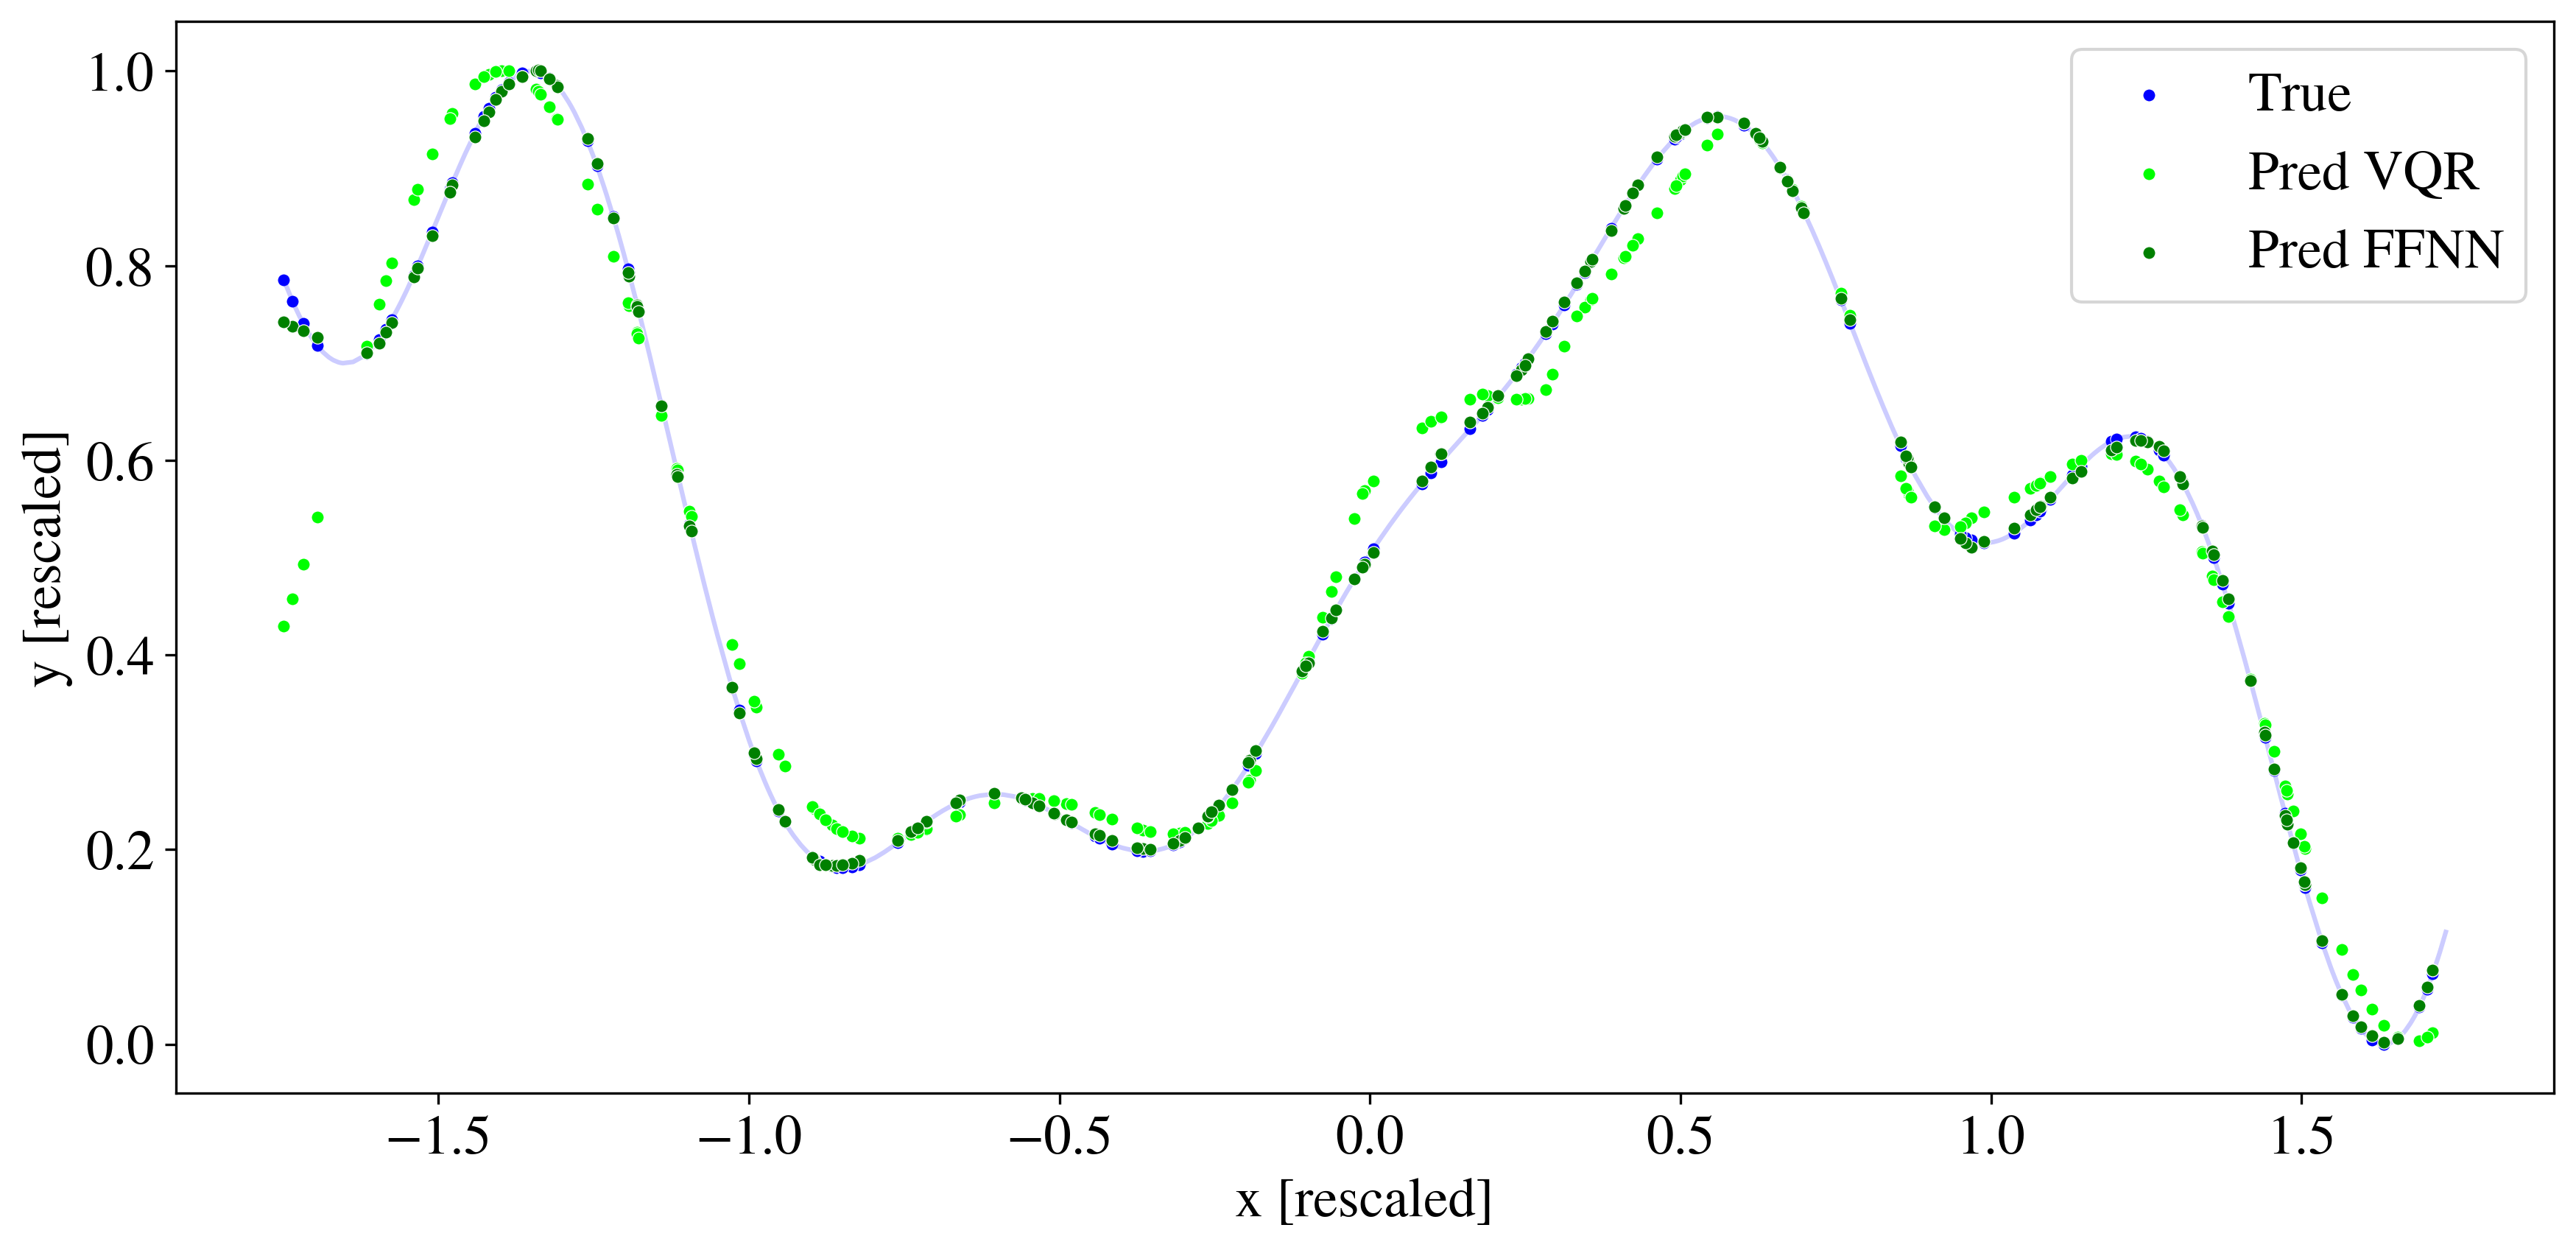

In [395]:
Xplot = np.concatenate([X_train[:,0], X_test[:,0], X_val[:,0]], axis=0)
Yplot = np.concatenate([y_train, y_test, y_val], axis=0)

plotData = pd.DataFrame([*zip(Yplot,Xplot)], columns=["y", "x"])
plotData.sort_values("x", inplace=True)

if nFeatures == 1:
    fig = plt.figure(figsize=(12,6))
    plt.scatter(X_test, y_test, label="True", s=17, color="blue", ec="white", lw=0.3)
    plt.plot(plotData["x"], plotData["y"], lw=1.5, alpha=0.2, color="blue", zorder=1)
    plt.scatter(X_test, y_pred, label="Pred VQR", s=17, color="lime", zorder=2, ec="white", lw=0.3)
    plt.scatter(X_test, y_pred_classical, label="Pred FFNN", s=17, color="green", zorder=2, ec="white", lw=0.3) 
    plt.legend()
    plt.xlabel("x [rescaled]")
    plt.ylabel("y [rescaled]")
    plt.tight_layout()
    
#fig.savefig(f"Figures/true_pred_plot_Comparison_{datasetName}.pdf", format="pdf", pad_inches=0)

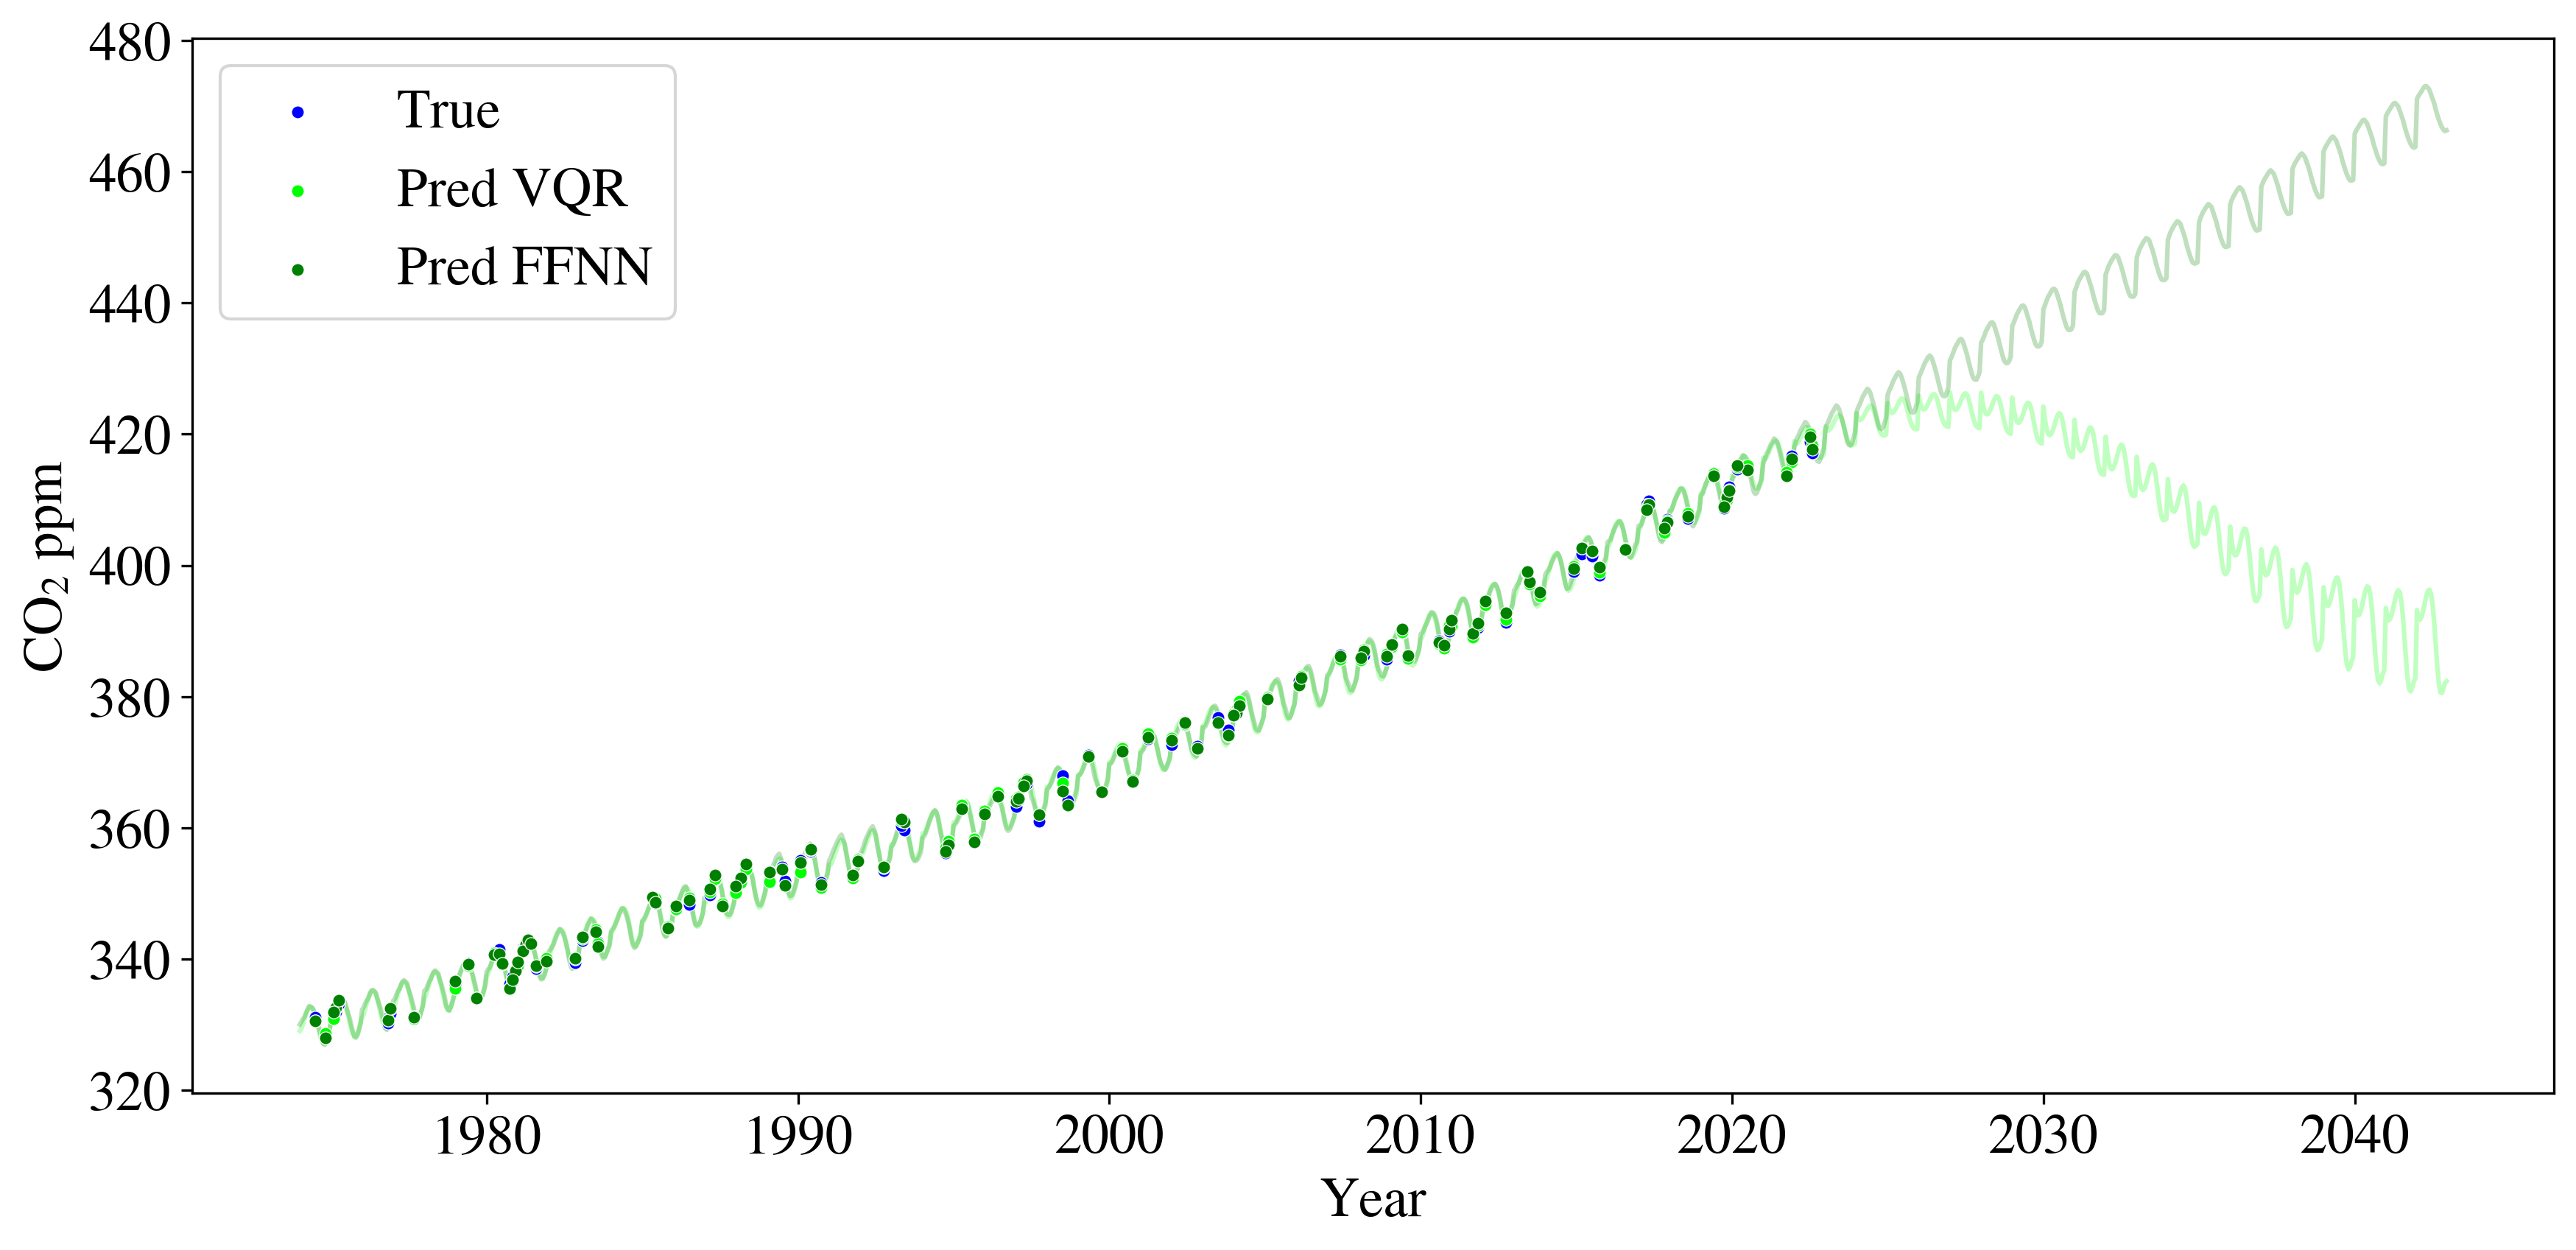

In [288]:
#for CO2 data

def rescaleInput(X, yearStart=1974):
    x = np.unique(X[:,0])
    deltaYear = x[1]-x[0]
    yearDict = dict(zip(x,(x - x.min())/deltaYear + 1974))

    x = np.unique(X[:,1])
    deltaMonth = x[1]-x[0]
    
    monthDict = dict(zip(x,(x - x.min())/deltaMonth/len(x)*12))
    
    rescaled = []
    for row in X:
        rescaled.append([yearDict[row[0]],monthDict[row[1]]])

    return np.array(rescaled)

def rescaleInput1d(X):
    return (X-X_train.min())/(X_train.max()-X_train.min())*(2022.832877 - 1974.328767) + 1974.328767


def rescaleInput2d(X):
    Xres = rescaleInput(X)
    timeDecimal = []
    for row in Xres:
        timeDecimal.append(row[0] + row[1]/12)
        
    return timeDecimal

def rescale_output(y):
    return (y-y_train.min())/(y_train.max()-y_train.min())*(420.97-327.3) + 327.3

################################################################################################################################

y_pred = predict(X_test, params=bestParams, 
                 nFeatures=nFeatures,
                 ansatzType=trials_df.loc[idx_best,"Type of Ansatz Circuit"],
                 layers=int(trials_df.loc[idx_best,"Layers"]),
                 repeats = int(trials_df.loc[idx_best, "Repeats"])
                )
y_pred_classic = classicalModel.predict(X_test)

y_plot_test = rescale_output(y_test)
y_plot_pred = rescale_output(y_pred)
y_plot_pred_classic = rescale_output(y_pred_classic)



fig = plt.figure(figsize=(12,6))
#plt.title("Test Set Predictions and Extrapolation", size=28)


if INPUT_SHAPE[0] == 1:
    x_plot_test = rescaleInput1d(X_test)
    x_extrapolate = np.array([[i] for i in np.linspace(X_test.min(), X_test.max()+1.5, 1000)])
    y_extrapolate = predict(x_extrapolate, params=bestParams, 
                 nFeatures=nFeatures,
                 ansatzType=trials_df.loc[idx_best,"Type of Ansatz Circuit"],
                 layers=int(trials_df.loc[idx_best,"Layers"]),
                 repeats = int(trials_df.loc[idx_best, "Repeats"])
                )
    y_extrapolate_classic = classicalModel.predict(x_extrapolate)

    y_extrapolate = rescale_output(y_extrapolate)    
    y_extrapolate_classic = rescale_output(y_extrapolate_classic)

    x_plot_extrapolate = rescaleInput1d(x_extrapolate)
    
    plt.plot(x_plot_extrapolate, y_extrapolate, color="lime", lw=1.5, alpha=0.25, zorder=1)
    plt.plot(x_plot_extrapolate, y_extrapolate_classic, color="green", lw=1.5, alpha=0.25, zorder=2)

    
    plt.scatter(x_plot_test, y_plot_test, s=17, color="blue", label="True", ec="white", lw=0.3)   
    plt.scatter(x_plot_test, y_plot_pred, s=17, color="lime", label="Pred VQR", ec="white", lw=0.3)
    plt.scatter(x_plot_test, y_plot_pred_classic, s=17, color="green", label="Pred FFNN", ec="white", lw=0.3)
    
    plt.xlabel("Year")
    plt.ylabel(r"CO${}_2$ ppm")

    plt.legend()



if INPUT_SHAPE[0] == 2:
    deltaYear = np.unique(X_test[:,0])[1] - np.unique(X_test[:,0])[0]
    deltaMonth = np.unique(X_test[:,1])[1] - np.unique(X_test[:,1])[0]

    x_extrapolate = []
    for i in np.arange(X_train[:,0].min(), X_train[:,0].max()+1.5, deltaYear):
        for j in np.linspace(X_train[:,1].min(), X_train[:,1].max(), 20, endpoint=False):
            x_extrapolate.append([i,j])
    x_extrapolate = np.array(x_extrapolate)
    
    y_extrapolate = predict(x_extrapolate, params=bestParams, 
                 nFeatures=nFeatures,
                 ansatzType=trials_df.loc[idx_best,"Type of Ansatz Circuit"],
                 layers=int(trials_df.loc[idx_best,"Layers"]),
                 repeats = int(trials_df.loc[idx_best, "Repeats"])
                )
    y_extrapolate_classic = classicalModel.predict(x_extrapolate)
    
    
    y_extrapolate = rescale_output(y_extrapolate)
    y_extrapolate_classic = rescale_output(y_extrapolate_classic)

    x_plot_extrapolate = rescaleInput2d(x_extrapolate)

    x_plot_test = rescaleInput2d(X_test)


    plt.plot(x_plot_extrapolate, y_extrapolate, color="lime", lw=1.5, alpha=0.25, zorder=1)
    plt.plot(x_plot_extrapolate, y_extrapolate_classic, color="green", lw=1.5, alpha=0.25, zorder=1)
    
    plt.scatter(x_plot_test, y_plot_test, s=17, color="blue", label="True", ec="white", lw=0.3)   
    plt.scatter(x_plot_test, y_plot_pred, s=17, color="lime", label="Pred VQR", ec="white", lw=0.3)
    plt.scatter(x_plot_test, y_plot_pred_classic, s=17, color="green", label="Pred FFNN", ec="white", lw=0.3)


    plt.xlabel("Year")
    plt.ylabel("CO${}_2$ ppm")
    plt.legend()
    
    

    
plt.tight_layout()
#plt.savefig(f"Figures/true_pred_plot_Comparison_extrapolate_{datasetName}.pdf", format="pdf", pad_inches=0)

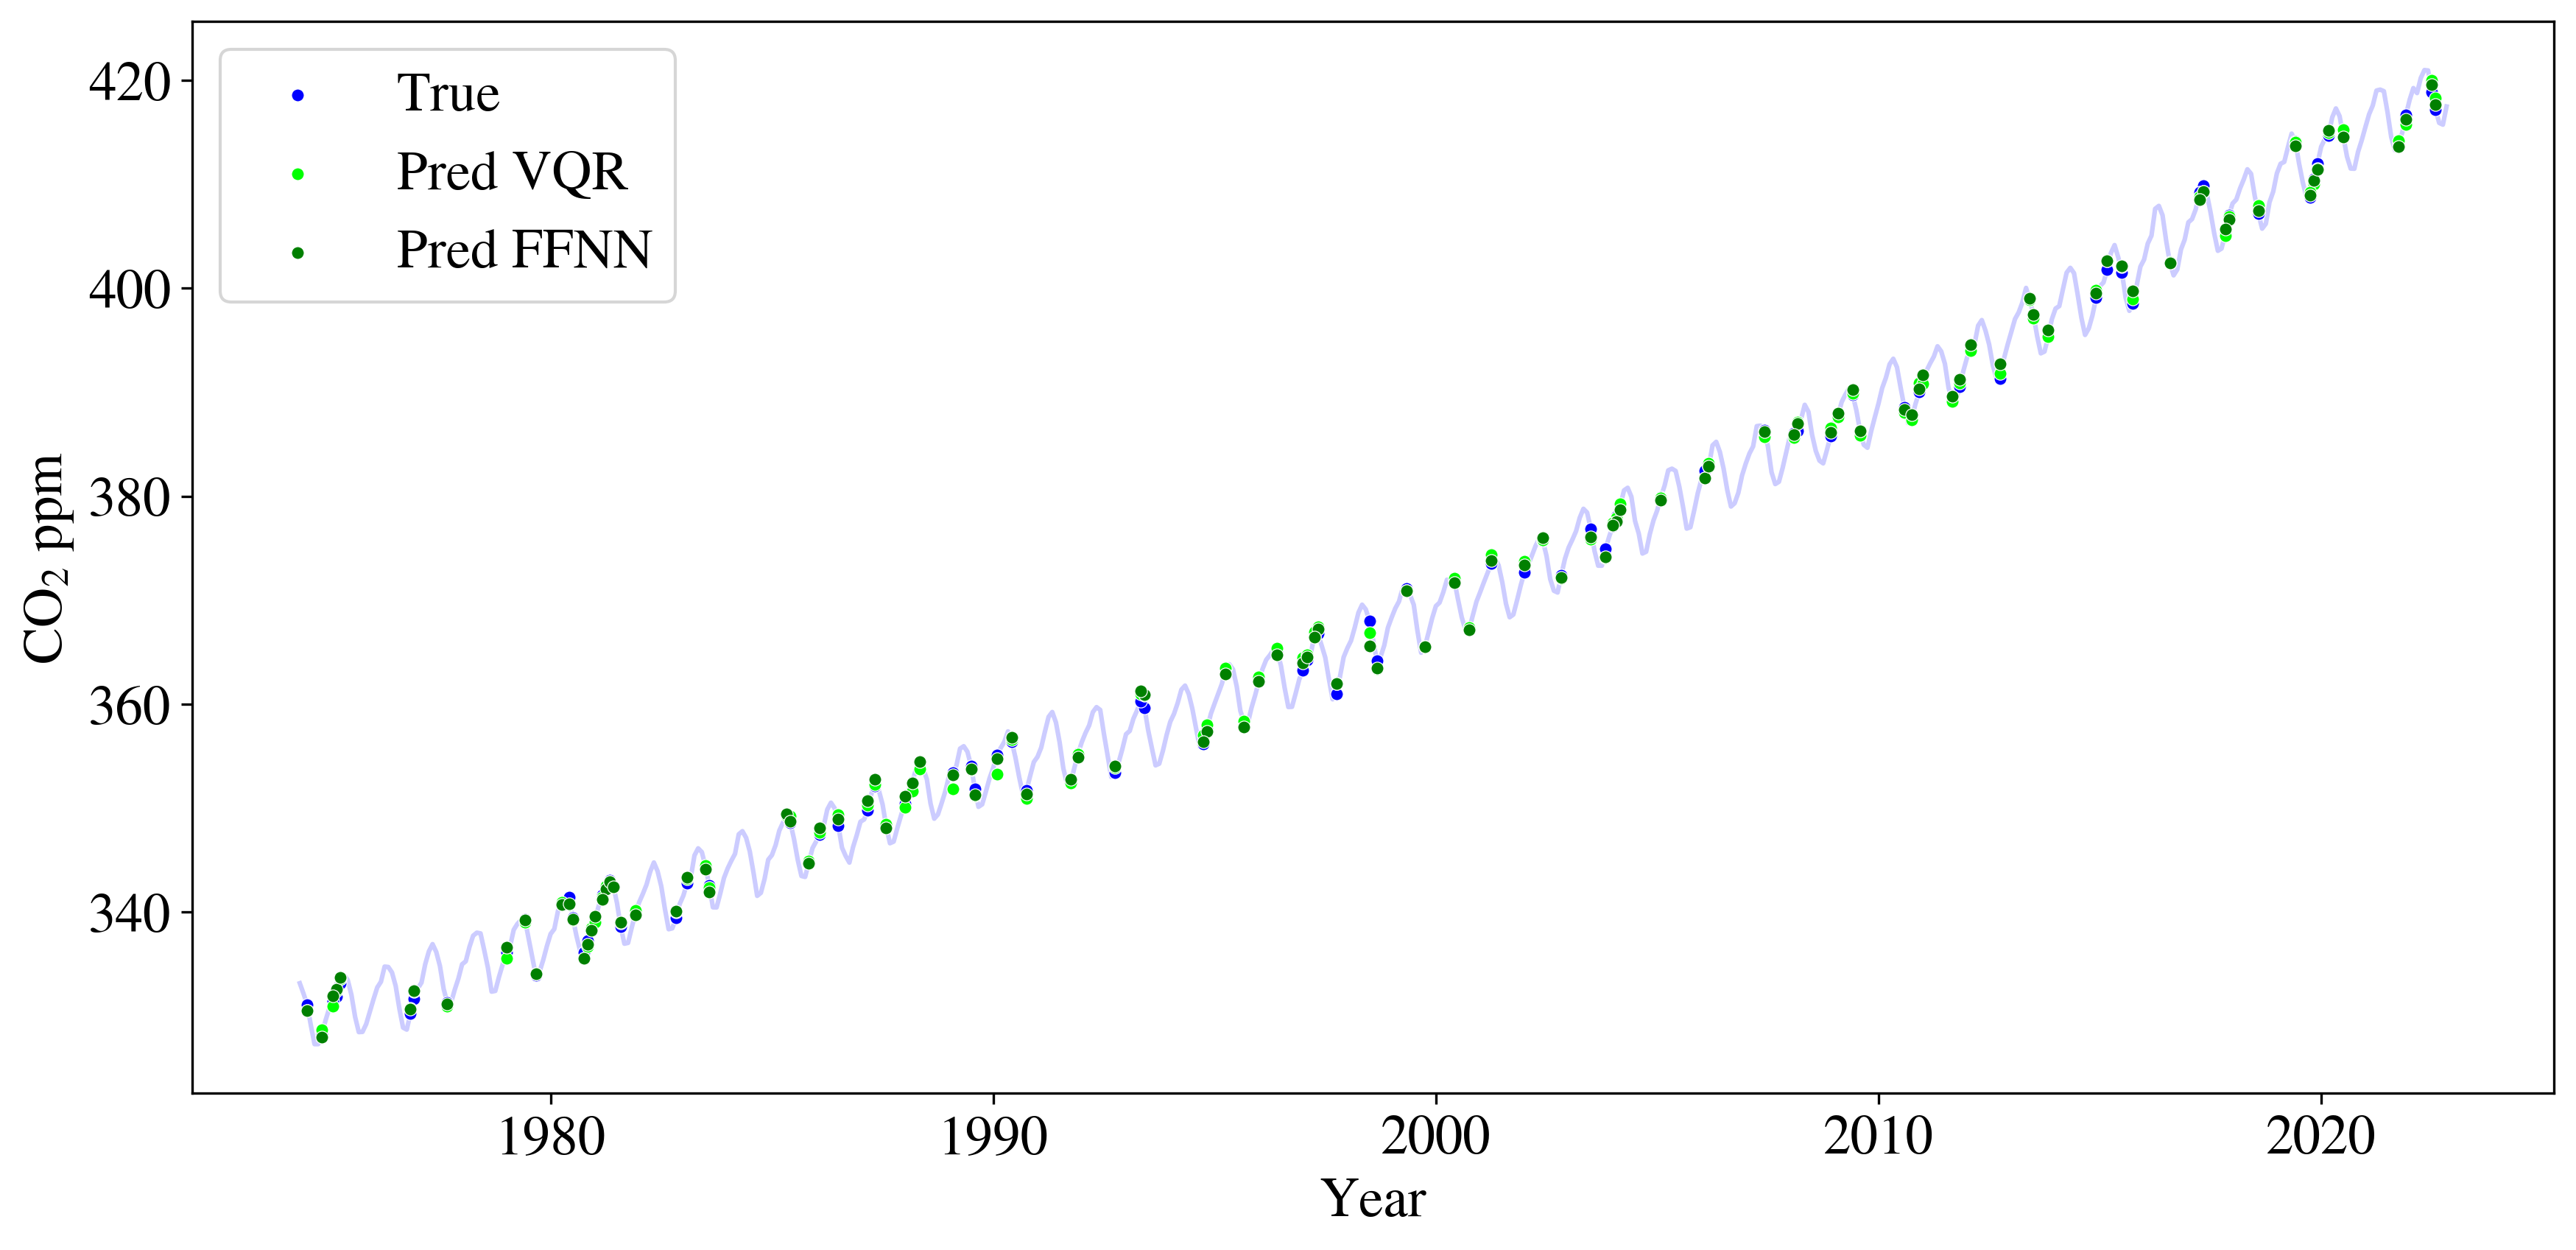

In [289]:
if nFeatures == 1:
    Xplot = np.concatenate([X_train[:,0], X_test[:,0], X_val[:,0]], axis=0)
else:
    Xplot = np.concatenate([X_train, X_test, X_val], axis=0)
Yplot = np.concatenate([y_train, y_test, y_val], axis=0)

plotData = pd.DataFrame([*zip(Yplot,[*Xplot])], columns=["y", "x"])

plotData["y"] = rescale_output(plotData["y"])





if nFeatures == 1:
    plotData["x"] = rescaleInput1d(plotData["x"])
if nFeatures == 2:
    plotData["x"] = rescaleInput2d(np.stack(plotData["x"].to_list()))

plotData.sort_values("x", inplace=True)
    
fig = plt.figure(figsize=(12,6))
plt.plot(plotData["x"], plotData["y"], lw=1.5, alpha=0.2, color="blue", zorder=1)
plt.scatter(x_plot_test, y_plot_test, s=17, color="blue", label="True", zorder=2, ec="white", lw=0.3)   
plt.scatter(x_plot_test, y_plot_pred, s=17, color="lime", label="Pred VQR", zorder=2, ec="white", lw=0.3)
plt.scatter(x_plot_test, y_plot_pred_classic, s=17, color="green", label="Pred FFNN", zorder=2, ec="white", lw=0.3)
plt.legend()
plt.xlabel("Year")
plt.ylabel("CO${}_2$ ppm")
plt.tight_layout()

#fig.savefig(f"Figures/true_pred_plot_Comparison_{datasetName}.pdf", format="pdf", pad_inches=0)

___
## Model Parameters During Training

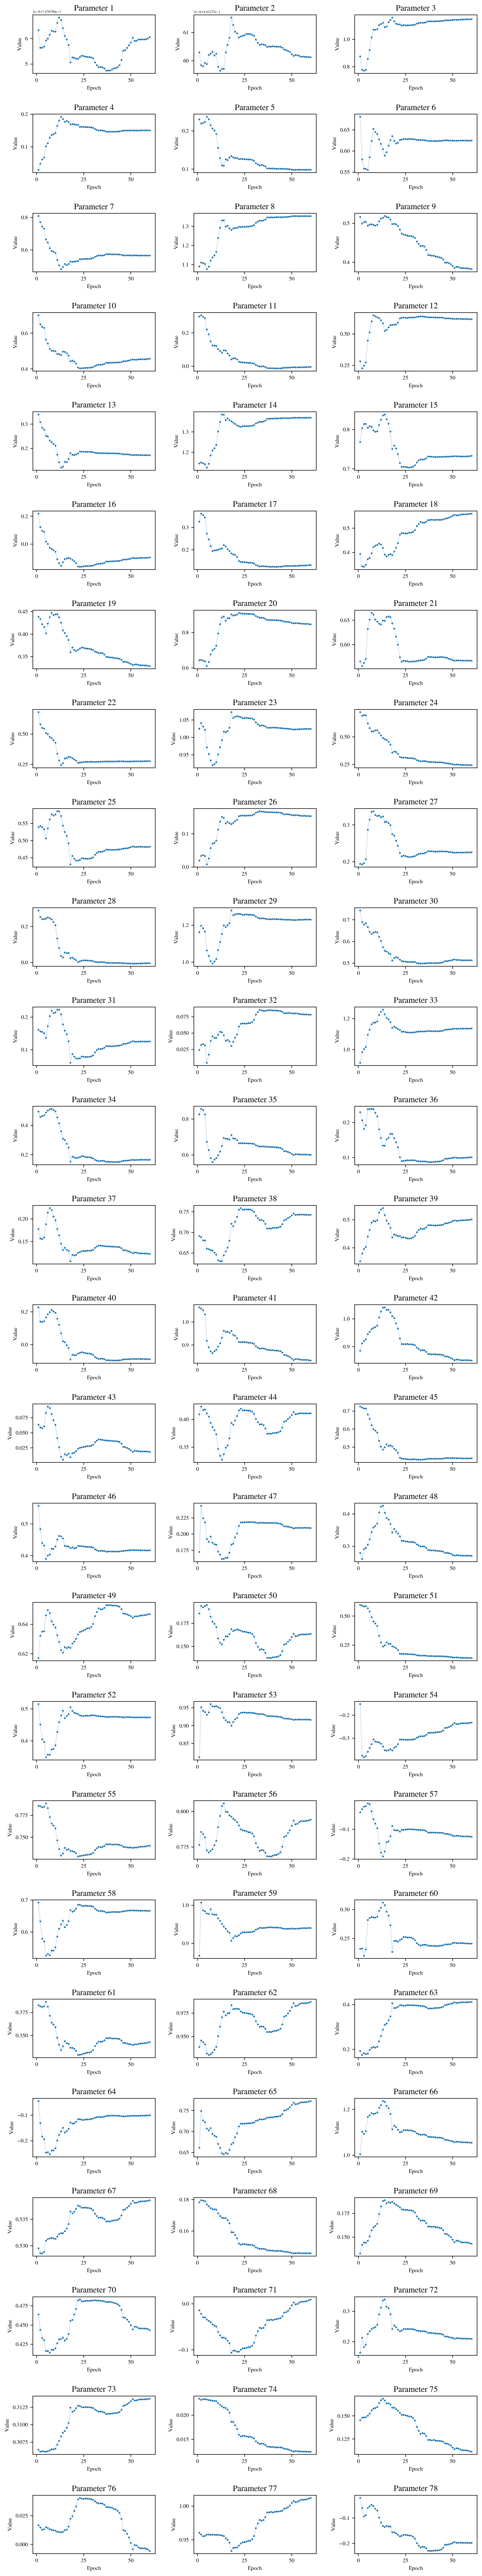

In [69]:
epochs = len(history["params_hist"])
nParams = len(history["params_hist"][0])
fig, axs = plt.subplots(nParams//3, 3, figsize=(10, 2*(nParams//3)))
#fig.suptitle("Parameters during training", y=0.99)

for i in range(nParams):
    p1 = [par[i] for par in history["params_hist"]]
    
    ax = axs[i//3][i%3]
    
    ax.set_title(f"Parameter {i+1}", size=12)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Value")
    ax.scatter(range(1,epochs+1), p1, marker='.', s=10)
    ax.plot(range(1,epochs+1), p1, alpha=0.15)
    #ax.set_yticks([])
    
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)
    ax.yaxis.get_offset_text().set_fontsize(5)
    
    
fig.tight_layout()

___